In [ ]:
# prompt: conectarse con https://github.com/cgrcostarica/umbrales-compras-publicas/blob/main/datos/hhi2.zip bajar el  zip y cargarlo a un df

import pandas as pd
import requests
from io import BytesIO
from zipfile import ZipFile

# URL del archivo zip
url = "https://github.com/cgrcostarica/umbrales-compras-publicas/blob/main/datos/hhi2.zip?raw=true"

# Descargar el archivo zip
response = requests.get(url)
response.raise_for_status()  # Verificar si la descarga fue exitosa

# Crear un objeto ZipFile a partir del contenido descargado
with ZipFile(BytesIO(response.content)) as zip_file:
  # Obtener el nombre del archivo CSV dentro del zip (asumiendo que hay un solo CSV)
  csv_filename = zip_file.namelist()[0]

  # Leer el archivo CSV en un DataFrame de pandas
  with zip_file.open(csv_filename) as csv_file:
    df = pd.read_csv(csv_file)

# Mostrar las primeras filas del DataFrame
print(df.head())


     NRO_SICOP                         NRO_OFERTA           CODIGO_PRODUCTO  \
0  20241103189  D20241120162748311917321416682710  801416079213316300000001   
1  20241103190  D20241127231837417617327711175840  781815079210401200000012   
2  20241103191  D20241120190759119717321512791210  391210119242332700000001   
3  20241103192  D20241126113902195817326427425940  861018089201264600000001   
4  20241103194  D20241125155627412317325717876400  471317079210783600000028   

   NRO_LINEA  NRO_ACTO  CEDULA_PROVEEDOR  CANTIDAD_ADJUDICADA  \
0          1   1101198         107210160                  1.0   
1          1   1103815        3101859977                  1.0   
2          1   1096997        3101059321                  1.0   
3          1   1100224        3101583156                  1.0   
4          1   1104283         113180496                  8.0   

   PRECIO_UNITARIO_ADJUDICADO TIPO_MONEDA  DESCUENTO         IVA  \
0                   7500000.0         CRC        0.0       0.000  

In [ ]:


# Aplicar la lógica para modificar el precio_unitario_adjudicado
df.loc[df['TIPO_MONEDA'] != 'CRC', 'PRECIO_UNITARIO_ADJUDICADO'] = df.loc[df['TIPO_MONEDA'] != 'CRC', 'PRECIO_UNITARIO_ADJUDICADO'] * df.loc[df['TIPO_MONEDA'] != 'CRC', 'TIPO_CAMBIO_DOLAR']

# Mostrar las primeras filas del DataFrame modificado
print(df.head())


     NRO_SICOP                         NRO_OFERTA           CODIGO_PRODUCTO  \
0  20241103189  D20241120162748311917321416682710  801416079213316300000001   
1  20241103190  D20241127231837417617327711175840  781815079210401200000012   
2  20241103191  D20241120190759119717321512791210  391210119242332700000001   
3  20241103192  D20241126113902195817326427425940  861018089201264600000001   
4  20241103194  D20241125155627412317325717876400  471317079210783600000028   

   NRO_LINEA  NRO_ACTO  CEDULA_PROVEEDOR  CANTIDAD_ADJUDICADA  \
0          1   1101198         107210160                  1.0   
1          1   1103815        3101859977                  1.0   
2          1   1096997        3101059321                  1.0   
3          1   1100224        3101583156                  1.0   
4          1   1104283         113180496                  8.0   

   PRECIO_UNITARIO_ADJUDICADO TIPO_MONEDA  DESCUENTO         IVA  \
0                   7500000.0         CRC        0.0       0.000  

In [ ]:
# prompt: genera un sudataframe sobre hhi2.csv de registro cuyo Fecha de registro inicia con 2020, 2021 y 2022 y guardelos como 2020a2022.csv


# Filtra las filas donde la 'FECHA_REGISTRO' comienza con '2020', '2021' o '2022'
df_filtered_20_22 = df[df['FECHA_REGISTRO'].astype(str).str.startswith(('2020', '2021', '2022'))]

# Filtra las filas donde la 'FECHA_REGISTRO' comienza con '2023' o '2024'
df_filtered_23_24 = df[df['FECHA_REGISTRO'].astype(str).str.startswith(('2023','2024'))]


In [ ]:

# Guarda el subconjunto filtrado en un nuevo archivo CSV
df_filtered_20_22.to_csv('2020a2022.csv', index=False)
df_filtered_23_24.to_csv('2023a2024.csv', index=False)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import os
import warnings

# Suprimir advertencias
warnings.filterwarnings('ignore')

def calculate_hhi_using_columns(market_data, provider_col, price_col, quantity_col):
    """
    Calcula el HHI usando nombres de columnas específicos.
    """
    market_data.loc[:, 'transaction_value'] = market_data[price_col] * market_data[quantity_col]
    provider_values = market_data.groupby(provider_col)['transaction_value'].sum()
    total_market_value = provider_values.sum()

    if total_market_value > 0:
        market_shares = (provider_values / total_market_value) * 100
        hhi = np.sum(market_shares ** 2)
        return hhi
    else:
        return 0

def create_hhi_histogram(results_df, period, output_dir="."):
    """
    Crea un histograma de distribución de HHI por período similar al mostrado
    en la imagen de referencia.

    Args:
        results_df (DataFrame): DataFrame con los resultados del análisis HHI
        period (str): Período de análisis (ej. "2020-2022")
        output_dir (str): Directorio donde guardar el archivo

    Returns:
        str: Ruta del archivo generado
    """
    # Definir colores para los niveles de concentración
    concentration_colors = {
        'Altamente concentrado': '#ff6b6b',      # Rojo
        'Moderadamente concentrado': '#ffa86b',  # Naranja
        'No concentrado': '#6bff6b'              # Verde
    }

    # Nombre del archivo de salida
    output_filename = os.path.join(output_dir, f'histograma_hhi_segmentos_{period}.png')

    # Crear figura con tamaño estándar
    plt.figure(figsize=(10, 6))

    # Definir bins del histograma con intervalos de 500 puntos
    max_hhi = max(9500, results_df['hhi'].max())  # Asegurarse de llegar al menos a 9500
    bin_edges = np.arange(0, max_hhi + 500, 500)  # Crear bins de 500 en 500

    # Calcular histograma
    hist, _ = np.histogram(results_df['hhi'], bins=bin_edges)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Asignar colores según nivel de concentración
    bar_colors = []
    for center in bin_centers:
        if center < 1500:
            bar_colors.append(concentration_colors['No concentrado'])
        elif center < 2500:
            bar_colors.append(concentration_colors['Moderadamente concentrado'])
        else:
            bar_colors.append(concentration_colors['Altamente concentrado'])

    # Dibujar las barras
    bars = plt.bar(bin_centers, hist, width=450, color=bar_colors, edgecolor='white', alpha=0.8, linewidth=1)

    # Añadir etiquetas con la cantidad en cada barra
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # Solo mostrar etiquetas en barras con valores
            plt.text(
                bar.get_x() + bar.get_width()/2,
                height,
                f'{int(height)}',  # Cantidad de segmentos
                ha='center',
                va='bottom',
                fontsize=10,
                fontweight='bold'
            )

    # Configurar título y etiquetas
    plt.title(f'Distribución del Índice HHI por Categoría (2 dígitos) {period}', fontsize=14)
    plt.xlabel('HHI', fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)

    # Configurar ejes
    plt.xlim(0, max_hhi)
    max_freq = max(hist) * 1.15  # Dar espacio para las etiquetas
    plt.ylim(0, max_freq)

    # Configurar ticks del eje X cada 500 puntos
    plt.xticks(bin_edges, rotation=0)

    # Añadir líneas verticales en los umbrales
    plt.axvline(x=1500, color='black', linestyle='--', linewidth=1.5)
    plt.axvline(x=2500, color='black', linestyle='--', linewidth=1.5)

    # Añadir anotaciones para los umbrales
    plt.annotate('Moderadamente\nconcentrado\n(HHI ≥1500)',
                xy=(1500, max_freq*0.5),
                xytext=(1000, max_freq*0.5),
                arrowprops=dict(arrowstyle='->'),
                ha='center')

    plt.annotate('Altamente\nconcentrado\n(HHI = 2500)',
                xy=(2500, max_freq*0.5),
                xytext=(3000, max_freq*0.5),
                arrowprops=dict(arrowstyle='->'),
                ha='center')

    # Añadir leyenda para los colores
    legend_elements = [
        Patch(facecolor=concentration_colors['No concentrado'], label='No concentrado (HHI < 1500)'),
        Patch(facecolor=concentration_colors['Moderadamente concentrado'], label='Moderadamente concentrado (1500 < HHI < 2500)'),
        Patch(facecolor=concentration_colors['Altamente concentrado'], label='Altamente concentrado (HHI > 2500)')
    ]

    plt.legend(handles=legend_elements, title="Nivel de Concentración",
              loc='upper right', fontsize=9)

    # Añadir grid
    plt.grid(True, axis='y', linestyle='--', alpha=0.3)

    # Ajustar layout
    plt.tight_layout()

    # Guardar la figura con alta resolución
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    plt.close()

    print(f"Histograma de distribución de HHI guardado como '{output_filename}'")
    return output_filename

def create_scatter_plot(results_df, period, output_dir="."):
    """
    Crea el gráfico de dispersión principal (relación entre número de proveedores y HHI)

    Args:
        results_df (DataFrame): DataFrame con resultados de análisis
        period (str): Período de análisis
        output_dir (str): Directorio de salida

    Returns:
        str: Ruta del archivo generado
    """
    # Definir colores para los niveles de concentración
    concentration_colors = {
        'Altamente concentrado': '#ff6b6b',
        'Moderadamente concentrado': '#ffa86b',
        'No concentrado': '#6bff6b'
    }

    output_filename = os.path.join(output_dir, f'scatter_segmentos_{period}.png')

    # Asignar colores a cada punto según su nivel de concentración
    colors = [concentration_colors[conc] for conc in results_df['concentration']]

    # Tamaño del punto proporcional al número de productos
    sizes = results_df['num_products'].clip(lower=10) / results_df['num_products'].max() * 500 + 50

    # Crear figura con tamaño fijo
    plt.figure(figsize=(8, 6))

    # Crear el scatter plot
    scatter = plt.scatter(
        results_df['num_providers'],
        results_df['hhi'],
        c=colors,
        s=sizes,
        alpha=0.7,
        edgecolors='white',
        linewidth=0.5
    )

    # Agregar líneas horizontales para los umbrales de concentración
    plt.axhline(y=2500, color='black', linestyle='--', linewidth=1.0, alpha=0.7)
    plt.axhline(y=1500, color='black', linestyle='--', linewidth=1.0, alpha=0.7)

    # Agregar etiquetas en las líneas horizontales
    plt.text(
        results_df['num_providers'].max() * 0.5,
        2500,
        'HHI = 2500 (Altamente concentrado)',
        fontsize=8,
        weight='bold',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=2),
        va='bottom',
        ha='center'
    )

    plt.text(
        results_df['num_providers'].max() * 0.5,
        1500,
        'HHI = 1500 (Moderadamente concentrado)',
        fontsize=8,
        weight='bold',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=2),
        va='bottom',
        ha='center'
    )

    # Agregar la curva teórica para mercados con participación igual
    x_values = np.linspace(1, results_df['num_providers'].max() * 1.1, 1000)
    y_values = 10000 / x_values  # HHI para participación igual de mercado
    plt.plot(x_values, y_values, 'k--', alpha=0.5, label='Participación igual (10000/n)')

    # Configurar título y etiquetas
    plt.title(f'Relación entre Número de Proveedores y HHI por Segmento (2 dígitos)\n{period}',
            fontsize=12, pad=10)
    plt.xlabel('Número de Proveedores', fontsize=10, labelpad=8)
    plt.ylabel('Índice Herfindahl-Hirschman (HHI)', fontsize=10, labelpad=8)

    # Establecer límites para los ejes
    max_providers = min(700, results_df['num_providers'].max() * 1.1)
    plt.xlim(0, max_providers)
    plt.ylim(0, min(10000, results_df['hhi'].max() * 1.1))

    # Etiquetar segmentos con valores extremos
    for _, row in results_df.tail(10).iterrows():  # Top 10 menos concentrados
        plt.text(
            row['num_providers'] + 5,
            row['hhi'] + 100,
            f"{row['segment_code']}",
            fontsize=8,
            weight='bold',
            backgroundcolor='white',
            alpha=0.8,
            ha='left',
            va='bottom'
        )

    # Añadir leyenda
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=concentration_colors['Altamente concentrado'],
              markersize=8, label='Altamente concentrado (HHI > 2500)'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=concentration_colors['Moderadamente concentrado'],
              markersize=8, label='Moderadamente concentrado (1500 < HHI < 2500)'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=concentration_colors['No concentrado'],
              markersize=8, label='No concentrado (HHI < 1500)'),
        Line2D([0], [0], linestyle='--', color='k', alpha=0.5, label='Participación igual (10000/n)')
    ]

    plt.legend(handles=legend_elements, loc='upper right', fontsize=8, framealpha=0.8)

    # Añadir nota sobre el tamaño de los puntos
    plt.figtext(0.5, 0.01, 'El tamaño de los puntos representa la cantidad de productos en cada Segmento',
                ha='center', fontsize=8, style='italic')

    # Mejorar la cuadrícula
    plt.grid(True, alpha=0.3)

    # Ajustar layout
    plt.tight_layout(pad=1.5, rect=[0, 0.03, 1, 0.97])

    # Guardar la figura con alta resolución
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    plt.close()

    print(f"Gráfico de dispersión guardado como '{output_filename}'")
    return output_filename

def create_top_concentrated_table(results_df, period, output_dir="."):
    """
    Crea la tabla con los 20 segmentos más concentrados

    Args:
        results_df (DataFrame): DataFrame con resultados de análisis
        period (str): Período de análisis
        output_dir (str): Directorio de salida

    Returns:
        str: Ruta del archivo generado
    """
    # Definir colores para los niveles de concentración
    concentration_colors = {
        'Altamente concentrado': '#ff6b6b',
        'Moderadamente concentrado': '#ffa86b',
        'No concentrado': '#6bff6b'
    }

    output_filename = os.path.join(output_dir, f'top20_segmentos_concentrados_{period}.png')

    # Obtener los 20 segmentos más concentrados
    top20 = results_df.head(20)

    # Crear figura y eje
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.title(f'Top 20 Segmentos con Mayor Concentración (HHI) {period}', fontsize=12, pad=15)

    # Preparar los datos para la tabla
    top20['hhi'] = top20['hhi'].round(1)

    # Seleccionar columnas para mostrar
    display_columns = ['segment_code', 'num_providers', 'num_products', 'num_offers', 'hhi', 'concentration']

    # Preparar los datos
    table_data = top20[display_columns].values

    # Preparar los colores de las celdas
    cell_colors = []
    for _, row in top20.iterrows():
        if row['concentration'] == 'Altamente concentrado':
            base_color = concentration_colors['Altamente concentrado']
        elif row['concentration'] == 'Moderadamente concentrado':
            base_color = concentration_colors['Moderadamente concentrado']
        else:
            base_color = concentration_colors['No concentrado']

        lighter_color = mcolors.to_rgba(base_color, alpha=0.3)
        row_colors = [lighter_color] * len(display_columns)
        cell_colors.append(row_colors)

    # Traducir nombres de columnas
    column_translations = {
        'segment_code': 'Código de Segmento',
        'num_providers': 'N° Proveedores',
        'num_offers': 'N° Ofertas',
        'num_products': 'N° Productos',
        'num_transactions': 'N° Transacciones',
        'hhi': 'HHI',
        'concentration': 'Nivel de Concentración'
    }

    column_labels = [column_translations.get(col, col) for col in display_columns]

    # Crear la tabla
    table = plt.table(
        cellText=table_data,
        colLabels=column_labels,
        loc='center',
        cellLoc='center',
        cellColours=cell_colors,
        colColours=['#f0f0f0'] * len(display_columns),
        bbox=[0.05, 0.05, 0.9, 0.8]
    )

    # Estilizar la tabla
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1.2, 1.5)

    # Añadir leyenda para explicar los colores
    legend_elements = [
        plt.Rectangle((0,0), 1, 1, facecolor=mcolors.to_rgba(concentration_colors['Altamente concentrado'], alpha=0.3),
                     label='Altamente concentrado (HHI > 2500)'),
        plt.Rectangle((0,0), 1, 1, facecolor=mcolors.to_rgba(concentration_colors['Moderadamente concentrado'], alpha=0.3),
                     label='Moderadamente concentrado (1500 < HHI < 2500)'),
        plt.Rectangle((0,0), 1, 1, facecolor=mcolors.to_rgba(concentration_colors['No concentrado'], alpha=0.3),
                     label='No concentrado (HHI < 1500)')
    ]

    plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=3, fontsize=8)

    # Añadir nota de pie de página
    plt.figtext(0.5, 0.01, f'Fuente: Análisis de datos SICOP {period} - Agrupado por segmento (2 dígitos)',
                ha='center', fontsize=8, style='italic')

    # Guardar la imagen
    plt.tight_layout()
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    plt.close()

    print(f"Tabla de top 20 segmentos más concentrados guardada como '{output_filename}'")
    return output_filename

def create_bottom_concentrated_table(results_df, period, output_dir="."):
    """
    Crea la tabla con los 20 segmentos menos concentrados

    Args:
        results_df (DataFrame): DataFrame con resultados de análisis
        period (str): Período de análisis
        output_dir (str): Directorio de salida

    Returns:
        str: Ruta del archivo generado
    """
    # Definir colores para los niveles de concentración
    concentration_colors = {
        'Altamente concentrado': '#ff6b6b',
        'Moderadamente concentrado': '#ffa86b',
        'No concentrado': '#6bff6b'
    }

    output_filename = os.path.join(output_dir, f'top20_segmentos_menos_concentrados_{period}.png')

    # Obtener los 20 segmentos menos concentrados
    bottom20 = results_df.tail(20)

    # Crear figura y eje
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.title(f'Top 20 Segmentos con Menor Concentración (HHI) {period}', fontsize=12, pad=15)

    # Preparar los datos para la tabla
    bottom20['hhi'] = bottom20['hhi'].round(1)

    # Seleccionar columnas para mostrar
    display_columns = ['segment_code', 'num_providers', 'num_products', 'num_offers', 'hhi', 'concentration']

    # Preparar los datos
    table_data = bottom20[display_columns].values

    # Preparar los colores de las celdas
    cell_colors = []
    for _, row in bottom20.iterrows():
        if row['concentration'] == 'Altamente concentrado':
            base_color = concentration_colors['Altamente concentrado']
        elif row['concentration'] == 'Moderadamente concentrado':
            base_color = concentration_colors['Moderadamente concentrado']
        else:
            base_color = concentration_colors['No concentrado']

        lighter_color = mcolors.to_rgba(base_color, alpha=0.3)
        row_colors = [lighter_color] * len(display_columns)
        cell_colors.append(row_colors)

    # Traducir nombres de columnas
    column_translations = {
        'segment_code': 'Código de Segmento',
        'num_providers': 'N° Proveedores',
        'num_offers': 'N° Ofertas',
        'num_products': 'N° Productos',
        'num_transactions': 'N° Transacciones',
        'hhi': 'HHI',
        'concentration': 'Nivel de Concentración'
    }

    column_labels = [column_translations.get(col, col) for col in display_columns]

    # Crear la tabla
    table = plt.table(
        cellText=table_data,
        colLabels=column_labels,
        loc='center',
        cellLoc='center',
        cellColours=cell_colors,
        colColours=['#f0f0f0'] * len(display_columns),
        bbox=[0.05, 0.05, 0.9, 0.8]
    )

    # Estilizar la tabla
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1.2, 1.5)

    # Añadir leyenda para explicar los colores
    legend_elements = [
        plt.Rectangle((0,0), 1, 1, facecolor=mcolors.to_rgba(concentration_colors['Altamente concentrado'], alpha=0.3),
                     label='Altamente concentrado (HHI > 2500)'),
        plt.Rectangle((0,0), 1, 1, facecolor=mcolors.to_rgba(concentration_colors['Moderadamente concentrado'], alpha=0.3),
                     label='Moderadamente concentrado (1500 < HHI < 2500)'),
        plt.Rectangle((0,0), 1, 1, facecolor=mcolors.to_rgba(concentration_colors['No concentrado'], alpha=0.3),
                     label='No concentrado (HHI < 1500)')
    ]

    plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=3, fontsize=8)

    # Añadir nota de pie de página
    plt.figtext(0.5, 0.01, f'Fuente: Análisis de datos SICOP {period} - Agrupado por segmento (2 dígitos)',
                ha='center', fontsize=8, style='italic')

    # Guardar la imagen
    plt.tight_layout()
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    plt.close()

    print(f"Tabla de top 20 segmentos menos concentrados guardada como '{output_filename}'")
    return output_filename

def generate_plots_for_period(file_path, period, output_dir=None):
    """
    Genera gráficos de análisis HHI para un período, incluyendo histograma,
    los 20 segmentos más concentrados y menos concentrados.

    Args:
        file_path (str): Ruta al archivo CSV con los datos
        period (str): Período de los datos (ej. "2020-2022")
        output_dir (str, opcional): Directorio para guardar las imágenes

    Returns:
        dict: Diccionario con las rutas de los archivos generados
    """
    # Configurar directorio de salida
    if output_dir is None:
        output_dir = "."

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Configurar el estilo de las visualizaciones
    plt.style.use('seaborn-v0_8-whitegrid')

    # Colores para los niveles de concentración
    concentration_colors = {
        'Altamente concentrado': '#ff6b6b',
        'Moderadamente concentrado': '#ffa86b',
        'No concentrado': '#6bff6b'
    }

    print(f"Cargando datos desde {file_path}...")
    df = pd.read_csv(file_path)

    print("Columnas disponibles en el CSV:")
    print(df.columns.tolist())

    # Mapeo para los nombres de columnas según la muestra
    column_name_mapping = {
        'CODIGO_PRODUCTO': 'CODIGO_PRODUCTO',
        'NRO_OFERTA': 'NRO_ACTO',  # Usando NRO_ACTO como indicado
        'CEDULA_PROVEEDOR': 'CEDULA_PROVEEDOR',
        'CANTIDAD_ADJUDICADA': 'CANTIDAD_ADJUDICADA',
        'PRECIO_UNITARIO_ADJUDICADO': 'PRECIO_UNITARIO_ADJUDICADO'
    }

    # Obtener nombres de columnas
    codigo_producto_col = column_name_mapping['CODIGO_PRODUCTO']
    nro_oferta_col = column_name_mapping['NRO_OFERTA']
    cedula_proveedor_col = column_name_mapping['CEDULA_PROVEEDOR']
    cantidad_adjudicada_col = column_name_mapping['CANTIDAD_ADJUDICADA']
    precio_unitario_col = column_name_mapping['PRECIO_UNITARIO_ADJUDICADO']

    # Crear códigos de segmento (usando los primeros 2 dígitos del código de producto)
    df['codigo_producto_str'] = df[codigo_producto_col].astype(str)
    df['segment_code'] = df['codigo_producto_str'].str[:2]  # Solo 2 dígitos

    # Identificar segmentos válidos con al menos 3 ofertas distintas
    print("Identificando segmentos válidos...")
    segment_offer_counts = df.groupby('segment_code')[nro_oferta_col].nunique()
    valid_segments = segment_offer_counts[segment_offer_counts >= 3].index.tolist()

    print(f"Se encontraron {len(valid_segments)} segmentos válidos con al menos 3 ofertas distintas.")

    # Calcular HHI para cada segmento válido
    results = []

    for segment in valid_segments:
        segment_data = df[df['segment_code'] == segment]

        # Contar proveedores y ofertas únicas
        num_providers = segment_data[cedula_proveedor_col].nunique()
        num_offers = segment_data[nro_oferta_col].nunique()
        num_products = segment_data[codigo_producto_col].nunique()

        # Calcular HHI
        hhi_value = calculate_hhi_using_columns(
            segment_data,
            cedula_proveedor_col,
            precio_unitario_col,
            cantidad_adjudicada_col
        )

        # Categorizar la concentración
        if hhi_value < 1500:
            concentration = "No concentrado"
        elif 1500 <= hhi_value < 2500:
            concentration = "Moderadamente concentrado"
        else:
            concentration = "Altamente concentrado"

        # Guardar resultados
        results.append({
            'segment_code': segment,
            'num_transactions': len(segment_data),
            'num_providers': num_providers,
            'num_offers': num_offers,
            'num_products': num_products,
            'hhi': hhi_value,
            'concentration': concentration
        })

    # Convertir resultados a DataFrame y ordenar
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='hhi', ascending=False)

    # Guardar resultados en CSV
    results_csv = os.path.join(output_dir, f'resultados_hhi_segmentos_{period}.csv')
    results_df.to_csv(results_csv, index=False)
    print(f"Resultados guardados en '{results_csv}'")

    # Diccionario para almacenar rutas de archivos generados
    generated_files = {'csv_results': results_csv}

    # Generar todas las gráficas utilizando las funciones separadas
    generated_files['histogram'] = create_hhi_histogram(results_df, period, output_dir)
    generated_files['scatter_plot'] = create_scatter_plot(results_df, period, output_dir)
    generated_files['top20_table'] = create_top_concentrated_table(results_df, period, output_dir)
    generated_files['bottom20_table'] = create_bottom_concentrated_table(results_df, period, output_dir)

    # Generar estadísticas textuales
    total_segments = len(results_df)
    highly_concentrated = (results_df['concentration'] == 'Altamente concentrado').sum()
    moderately_concentrated = (results_df['concentration'] == 'Moderadamente concentrado').sum()
    not_concentrated = (results_df['concentration'] == 'No concentrado').sum()

    print(f"\nEstadísticas de concentración para el período {period}:")
    print(f"Total de segmentos analizados: {total_segments}")
    print(f"Altamente concentrados: {highly_concentrated} ({highly_concentrated/total_segments*100:.1f}%)")
    print(f"Moderadamente concentrados: {moderately_concentrated} ({moderately_concentrated/total_segments*100:.1f}%)")
    print(f"No concentrados: {not_concentrated} ({not_concentrated/total_segments*100:.1f}%)")

    print(f"\nTodas las visualizaciones para análisis HHI del período {period} han sido generadas exitosamente.")

    return generated_files

# Ejemplo de uso:

# generate_plots_for_period('datos_sicop_2023_2024.csv', '2023-2024')

In [ ]:
generate_plots_for_period('2020a2022.csv', '2020-2022')

Cargando datos desde 2020a2022.csv...
Columnas disponibles en el CSV:
['NRO_SICOP', 'NRO_OFERTA', 'CODIGO_PRODUCTO', 'NRO_LINEA', 'NRO_ACTO', 'CEDULA_PROVEEDOR', 'CANTIDAD_ADJUDICADA', 'PRECIO_UNITARIO_ADJUDICADO', 'TIPO_MONEDA', 'DESCUENTO', 'IVA', 'OTROS_IMPUESTOS', 'ACARREOS', 'TIPO_CAMBIO_CRC', 'TIPO_CAMBIO_DOLAR', 'FECHA_REGISTRO', 'NRO_PARTIDA']
Identificando segmentos válidos...
Se encontraron 57 segmentos válidos con al menos 3 ofertas distintas.
Resultados guardados en './resultados_hhi_segmentos_2020-2022.csv'
Histograma de distribución de HHI guardado como './histograma_hhi_segmentos_2020-2022.png'
Gráfico de dispersión guardado como './scatter_segmentos_2020-2022.png'
Tabla de top 20 segmentos más concentrados guardada como './top20_segmentos_concentrados_2020-2022.png'
Tabla de top 20 segmentos menos concentrados guardada como './top20_segmentos_menos_concentrados_2020-2022.png'

Estadísticas de concentración para el período 2020-2022:
Total de segmentos analizados: 57
Alt

{'csv_results': './resultados_hhi_segmentos_2020-2022.csv',
 'histogram': './histograma_hhi_segmentos_2020-2022.png',
 'scatter_plot': './scatter_segmentos_2020-2022.png',
 'top20_table': './top20_segmentos_concentrados_2020-2022.png',
 'bottom20_table': './top20_segmentos_menos_concentrados_2020-2022.png'}

In [ ]:
generate_plots_for_period('2023a2024.csv', '2023-2024')

Cargando datos desde 2023a2024.csv...
Columnas disponibles en el CSV:
['NRO_SICOP', 'NRO_OFERTA', 'CODIGO_PRODUCTO', 'NRO_LINEA', 'NRO_ACTO', 'CEDULA_PROVEEDOR', 'CANTIDAD_ADJUDICADA', 'PRECIO_UNITARIO_ADJUDICADO', 'TIPO_MONEDA', 'DESCUENTO', 'IVA', 'OTROS_IMPUESTOS', 'ACARREOS', 'TIPO_CAMBIO_CRC', 'TIPO_CAMBIO_DOLAR', 'FECHA_REGISTRO', 'NRO_PARTIDA']
Identificando segmentos válidos...
Se encontraron 57 segmentos válidos con al menos 3 ofertas distintas.
Resultados guardados en './resultados_hhi_segmentos_2023-2024.csv'
Histograma de distribución de HHI guardado como './histograma_hhi_segmentos_2023-2024.png'
Gráfico de dispersión guardado como './scatter_segmentos_2023-2024.png'
Tabla de top 20 segmentos más concentrados guardada como './top20_segmentos_concentrados_2023-2024.png'
Tabla de top 20 segmentos menos concentrados guardada como './top20_segmentos_menos_concentrados_2023-2024.png'

Estadísticas de concentración para el período 2023-2024:
Total de segmentos analizados: 57
Alt

{'csv_results': './resultados_hhi_segmentos_2023-2024.csv',
 'histogram': './histograma_hhi_segmentos_2023-2024.png',
 'scatter_plot': './scatter_segmentos_2023-2024.png',
 'top20_table': './top20_segmentos_concentrados_2023-2024.png',
 'bottom20_table': './top20_segmentos_menos_concentrados_2023-2024.png'}

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import os

def analizar_redes_segmentos(data_path, hhi_path, period, output_dir=None, n_segmentos=10):
    """
    Genera visualizaciones de redes para segmentos SICOP específicos en un período determinado.
    Identifica automáticamente los segmentos con menor concentración.

    Args:
        data_path (str o pd.DataFrame): Ruta al CSV con datos originales o DataFrame con los datos
        hhi_path (str o pd.DataFrame): Ruta al CSV con valores HHI o DataFrame con los valores
        period (str): Período de los datos (ej. "2020-2022")
        output_dir (str, opcional): Directorio para guardar las imágenes
        n_segmentos (int, opcional): Número de segmentos con menor concentración a identificar
            (por defecto 10)

    Returns:
        dict: Diccionario con las rutas de los archivos generados
    """
    # Configuración para mejor visualización
    plt.rcParams['figure.figsize'] = (16, 12)
    plt.rcParams['font.size'] = 12
    sns.set_style("whitegrid")

    # Configurar directorio de salida
    if output_dir is None:
        output_dir = "."

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Cargar los datos originales
    if isinstance(data_path, pd.DataFrame):
        print("Usando DataFrame proporcionado para los datos originales...")
        df = data_path
    else:
        # Cargar datos del CSV
        print(f"Cargando datos originales desde {data_path}...")
        df = pd.read_csv(data_path)

    # Cargar los datos de HHI
    if isinstance(hhi_path, pd.DataFrame):
        print("Usando DataFrame proporcionado para los valores HHI...")
        results_df = hhi_path
    else:
        # Cargar datos del CSV
        print(f"Cargando datos HHI desde {hhi_path}...")
        results_df = pd.read_csv(hhi_path)

    # Ordenar el dataframe results_df por HHI ascendente para obtener los de menor concentración
    results_df = results_df.sort_values(by='hhi', ascending=True)

    # Identificar los n_segmentos con menor concentración
    low_concentration = results_df.head(n_segmentos)['segment_code'].tolist()
    codigos_segmento = low_concentration

    # Obtener todos los segmentos disponibles
    if 'CODIGO_SEGMENTO' in df.columns:
        segmentos_disponibles = df['CODIGO_SEGMENTO'].unique().tolist()
    elif 'segment_code' in df.columns:
        segmentos_disponibles = df['segment_code'].unique().tolist()
    else:
        # Si no existe la columna, extraer los dos primeros dígitos del código de producto
        df['CODIGO_SEGMENTO'] = df['CODIGO_PRODUCTO'].astype(str).str[:2].astype(int)
        segmentos_disponibles = df['CODIGO_SEGMENTO'].unique().tolist()

    # Filtrar segmentos que realmente existen en los datos
    codigos_segmento = [seg for seg in codigos_segmento if seg in segmentos_disponibles]

    print(f"Analizando {len(codigos_segmento)} segmentos: {codigos_segmento}")

    # Filtrar solo los registros que corresponden a los códigos de segmento de interés
    if 'CODIGO_SEGMENTO' in df.columns:
        df_filtrado = df[df['CODIGO_SEGMENTO'].isin(codigos_segmento)]
    elif 'segment_code' in df.columns:
        df_filtrado = df[df['segment_code'].isin(codigos_segmento)]
    else:
        print("Error: No se encuentra una columna con el código de segmento.")
        return {}

    print(f"Se encontraron {len(df_filtrado)} transacciones para los segmentos seleccionados.")

    # Asegurar que existe la columna MONTO_TOTAL
    if 'MONTO_TOTAL' not in df_filtrado.columns:
        if 'CANTIDAD_ADJUDICADA' in df_filtrado.columns and 'PRECIO_UNITARIO_ADJUDICADO' in df_filtrado.columns:
            df_filtrado['MONTO_TOTAL'] = df_filtrado['CANTIDAD_ADJUDICADA'] * df_filtrado['PRECIO_UNITARIO_ADJUDICADO']
        elif 'transaction_value' in df_filtrado.columns:
            df_filtrado['MONTO_TOTAL'] = df_filtrado['transaction_value']
        else:
            print("Error: No se pueden determinar los montos totales de las transacciones.")
            return {}

    # Función para crear un grafo para cada segmento
    def crear_grafo_segmento(codigo_segmento, transacciones_df):
        """Crea un grafo para un segmento específico con todos los proveedores"""
        # Determinar qué columnas usar según los nombres en el DataFrame
        col_segmento = 'CODIGO_SEGMENTO' if 'CODIGO_SEGMENTO' in transacciones_df.columns else 'segment_code'
        col_proveedor = 'CEDULA_PROVEEDOR' if 'CEDULA_PROVEEDOR' in transacciones_df.columns else 'provider_id'
        col_monto = 'MONTO_TOTAL'

        # Filtrar transacciones para este segmento
        trans_segmento = transacciones_df[transacciones_df[col_segmento] == codigo_segmento]

        # Agrupar por proveedor y sumar montos
        proveedores = trans_segmento.groupby(col_proveedor)[col_monto].sum().reset_index()

        # Identificar los 5 proveedores principales (para mostrar etiquetas)
        top5_proveedores = proveedores.sort_values(col_monto, ascending=False).head(5)
        top5_cedulas = set(top5_proveedores[col_proveedor].tolist())

        # Crear grafo
        G = nx.Graph()

        # Añadir nodo central (segmento)
        G.add_node(f"S{codigo_segmento}",
                  tipo='segmento',
                  label=str(codigo_segmento),
                  size=800)

        # Agregar nodos de proveedores y enlaces
        for _, row in proveedores.iterrows():
            cedula = row[col_proveedor]
            monto_total = row[col_monto]

            # Determinar si este proveedor es uno de los 5 principales
            es_top5 = cedula in top5_cedulas

            # Añadir nodo de proveedor
            G.add_node(f"P{cedula}",
                      tipo='proveedor',
                      label=str(cedula),
                      size=150,
                      monto=monto_total,
                      mostrar_etiqueta=es_top5)

            # Añadir enlace entre segmento y proveedor con el monto como peso
            G.add_edge(f"S{codigo_segmento}", f"P{cedula}",
                      weight=monto_total,
                      monto=monto_total)

        return G

    # Crear grafos para todos los segmentos que tienen datos
    grafos_segmentos = {}
    for codigo in codigos_segmento:
        if 'CODIGO_SEGMENTO' in df_filtrado.columns and codigo in df_filtrado['CODIGO_SEGMENTO'].values:
            grafos_segmentos[codigo] = crear_grafo_segmento(codigo, df_filtrado)
        elif 'segment_code' in df_filtrado.columns and codigo in df_filtrado['segment_code'].values:
            grafos_segmentos[codigo] = crear_grafo_segmento(codigo, df_filtrado)
        else:
            # Si no hay datos para un segmento, creamos un grafo con solo el nodo central
            G = nx.Graph()
            G.add_node(f"S{codigo}", tipo='segmento', label=str(codigo), size=800)
            grafos_segmentos[codigo] = G

    # Función para visualizar un grafo de segmento
    def visualizar_grafo_segmento(codigo_segmento, G, ax=None, title=None, hhi_value=None, concentration=None):
        """Visualiza el grafo de un segmento con distancia de edges proporcional al monto"""
        if ax is None:
            _, ax = plt.subplots(figsize=(10, 8))

        # Definir colores según el código de segmento
        colores = {
            24: "#9C27B0",  # Morado
            25: "#607D8B",  # Gris azulado
            26: "#795548",  # Marrón
            40: "#00BCD4",  # Cian
            42: "#FF9800",  # Naranja
            46: "#2196F3",  # Azul
            53: "#4CAF50",  # Verde
            55: "#E91E63",  # Rosa
            73: "#FFC107",  # Amarillo
            78: "#F44336"   # Rojo
        }
        # Si no existe un color definido para este segmento, usar un color predeterminado
        color = colores.get(codigo_segmento, "#3F51B5")  # Azul índigo por defecto

        # Extraer nodos por tipo
        nodos_segmento = [n for n, attr in G.nodes(data=True) if attr.get('tipo') == 'segmento']
        nodos_proveedor = [n for n, attr in G.nodes(data=True) if attr.get('tipo') == 'proveedor']

        # Calcular posiciones basadas en el monto
        if nodos_proveedor:
            montos = {n: G.nodes[n].get('monto', 0) for n in nodos_proveedor}
            max_monto = max(montos.values()) if montos else 1

            # Calcular posiciones con distancia proporcional al monto
            pos = {}
            pos[f"S{codigo_segmento}"] = np.array([0, 0])  # Nodo central en el origen

            # Distribuir proveedores en un círculo
            num_proveedores = len(nodos_proveedor)
            angulo_incremento = 2 * np.pi / num_proveedores

            # Escala para normalizar distancias (montos más grandes = más lejos)
            min_radio = 0.3  # Radio mínimo para montos pequeños
            max_radio = 1.0  # Radio máximo para el monto más grande

            for i, nodo in enumerate(nodos_proveedor):
                angulo = i * angulo_incremento
                # Normalizar el monto para determinar la distancia (mayor monto = mayor distancia)
                monto_normalizado = montos[nodo] / max_monto
                radio = min_radio + (max_radio - min_radio) * monto_normalizado

                x = radio * np.cos(angulo)
                y = radio * np.sin(angulo)
                pos[nodo] = np.array([x, y])
        else:
            # Si no hay proveedores, solo colocar el nodo central
            pos = {f"S{codigo_segmento}": np.array([0, 0])}

        # Crear un efecto de gradiente para el fondo
        # Esto se hará dibujando un círculo relleno con un gradiente radial
        circle = plt.Circle((0, 0), 1.2, color=color, alpha=0.1)
        ax.add_patch(circle)

        # Dibujar nodos de proveedores si existen
        if nodos_proveedor:
            # Identificar nodos a destacar (top 5)
            nodos_top5 = [n for n in nodos_proveedor if G.nodes[n].get('mostrar_etiqueta', False)]
            nodos_resto = [n for n in nodos_proveedor if not G.nodes[n].get('mostrar_etiqueta', False)]

            # Dibujar primero los nodos no destacados
            if nodos_resto:
                nx.draw_networkx_nodes(G, pos,
                                      nodelist=nodos_resto,
                                      node_size=[G.nodes[n]['size'] for n in nodos_resto],
                                      node_color=color,
                                      alpha=0.5,
                                      node_shape='o',
                                      ax=ax)

            # Dibujar los nodos top 5 con mayor tamaño y opacidad
            if nodos_top5:
                nx.draw_networkx_nodes(G, pos,
                                      nodelist=nodos_top5,
                                      node_size=[G.nodes[n]['size'] * 1.5 for n in nodos_top5],
                                      node_color=color,
                                      alpha=0.9,
                                      node_shape='o',
                                      ax=ax)

        # Dibujar nodos de segmento
        nx.draw_networkx_nodes(G, pos,
                              nodelist=nodos_segmento,
                              node_size=[G.nodes[n]['size'] for n in nodos_segmento],
                              node_color=color,
                              alpha=1.0,
                              node_shape='o',
                              ax=ax)

        # Dibujar bordes
        if G.edges():
            # Separar bordes hacia nodos top 5 del resto
            edges_top5 = [(u, v) for u, v in G.edges() if (u in nodos_top5 or v in nodos_top5)]
            edges_resto = [(u, v) for u, v in G.edges() if not (u in nodos_top5 or v in nodos_top5)]

            # Dibujar bordes no destacados
            if edges_resto:
                nx.draw_networkx_edges(G, pos,
                                     edgelist=edges_resto,
                                     width=0.8,
                                     edge_color='blue',
                                     alpha=0.3,
                                     ax=ax)

            # Dibujar bordes destacados
            if edges_top5:
                nx.draw_networkx_edges(G, pos,
                                     edgelist=edges_top5,
                                     width=1.5,
                                     edge_color='blue',
                                     alpha=0.7,
                                     ax=ax)

        # Etiquetas solo para el nodo central y los 5 proveedores principales
        etiquetas = {}
        for n in nodos_segmento:
            etiquetas[n] = G.nodes[n]['label']

        for n in nodos_proveedor:
            if G.nodes[n].get('mostrar_etiqueta', False):
                cedula = G.nodes[n]['label']
                monto = G.nodes[n]['monto']
                etiquetas[n] = f"{cedula}\n({monto/1e6:.2f}M)"

        nx.draw_networkx_labels(G, pos,
                              labels=etiquetas,
                              font_size=9,
                              font_weight='bold',
                              font_color='black',
                              horizontalalignment='center',
                              verticalalignment='center',
                              ax=ax)

        # Título del grafo con información de HHI
        if title is None:
            if hhi_value is not None and concentration is not None:
                title = f"Segmento {codigo_segmento} - HHI: {hhi_value:.1f}\n{concentration}"
            else:
                title = f"Segmento {codigo_segmento}"

        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.axis('off')

        # Asegurar que los límites del gráfico son simétricos
        ax.set_xlim(-1.3, 1.3)
        ax.set_ylim(-1.3, 1.3)

        return ax

    # Visualizar todos los segmentos en una cuadrícula
    def visualizar_todos_segmentos(grafos_segmentos):
        """Visualiza todos los segmentos en una cuadrícula de gráficos"""
        num_segmentos = len(grafos_segmentos)
        # Determinar la cuadrícula basada en el número de segmentos
        if num_segmentos <= 4:
            filas, columnas = 2, 2
        elif num_segmentos <= 6:
            filas, columnas = 2, 3
        elif num_segmentos <= 9:
            filas, columnas = 3, 3
        else:
            filas, columnas = 4, 3  # Cambiado para que quepan los 10 segmentos

        fig, axs = plt.subplots(filas, columnas, figsize=(20, 20))  # Aumentado el tamaño vertical
        axs = axs.flatten()

        # Datos para la tabla
        tabla_data = []

        for i, codigo in enumerate(sorted(codigos_segmento)):
            if i < len(axs):
                G = grafos_segmentos[codigo]

                # Obtener HHI para este segmento
                hhi_value = None
                concentration = None
                if not results_df.empty:
                    segment_info = results_df[results_df['segment_code'] == codigo]
                    if not segment_info.empty:
                        hhi_value = segment_info.iloc[0]['hhi']
                        concentration = segment_info.iloc[0]['concentration']

                # Visualizar grafo
                visualizar_grafo_segmento(codigo, G, ax=axs[i], hhi_value=hhi_value, concentration=concentration)

                # Recopilar datos básicos
                num_proveedores = len([n for n in G.nodes() if G.nodes[n].get('tipo') == 'proveedor'])
                montos = [G.nodes[n].get('monto', 0) for n in G.nodes() if G.nodes[n].get('tipo') == 'proveedor']
                monto_total = sum(montos) if montos else 0

                # Top 5 proveedores por monto
                top_proveedores = []
                if num_proveedores > 0:
                    proveedores_info = [(n, G.nodes[n].get('monto', 0)) for n in G.nodes() if G.nodes[n].get('tipo') == 'proveedor']
                    top_proveedores = sorted(proveedores_info, key=lambda x: x[1], reverse=True)[:5]

                top_proveedores_str = ', '.join([f"{G.nodes[prov]['label']} ({monto/1e6:.2f}M)" for prov, monto in top_proveedores])

                tabla_data.append({
                    'Código': codigo,
                    'Proveedores': num_proveedores,
                    'Monto Total (M)': monto_total / 1e6,
                    'Top 5 Proveedores': top_proveedores_str,
                    'HHI': hhi_value if hhi_value is not None else 0,
                    'Concentración': concentration if concentration is not None else "No determinado"
                })

        # Eliminar ejes vacíos
        for i in range(len(codigos_segmento), len(axs)):
            fig.delaxes(axs[i])

        plt.tight_layout()
        plt.suptitle(f"Análisis de Redes por Segmento - Contrataciones Públicas {period}\nSegmentos con Menor Concentración",
                    fontsize=20, fontweight='bold', y=0.98)
        plt.subplots_adjust(top=0.9)

        return fig, tabla_data

    # Crear tabla simple
    def crear_tabla_simple(tabla_data):
        """Crea una tabla visual con datos básicos de cada segmento"""
        # Convertir a DataFrame para mejor manejo
        df_tabla = pd.DataFrame(tabla_data)

        # Ordenar por HHI ascendente
        df_tabla = df_tabla.sort_values('HHI')

        # Seleccionar columnas para mostrar
        columnas_mostrar = ['Código', 'Proveedores', 'Monto Total (M)', 'HHI', 'Concentración']

        # Asegurarse de que todas las columnas existen
        for col in columnas_mostrar:
            if col not in df_tabla.columns:
                if col == 'HHI':
                    df_tabla[col] = 0
                elif col == 'Concentración':
                    df_tabla[col] = "No determinado"
                else:
                    df_tabla[col] = ""

        df_tabla_simple = df_tabla[columnas_mostrar]

        # Configurar figura
        fig, ax = plt.subplots(figsize=(12, 8))  # Aumentado para más filas
        ax.axis('off')
        ax.axis('tight')

        # Definir colores para la tabla según la concentración
        concentration_colors = {
            'Altamente concentrado': plt.cm.Reds(np.linspace(0.4, 0.7, 1))[0],
            'Moderadamente concentrado': plt.cm.YlOrBr(np.linspace(0.4, 0.7, 1))[0],
            'No concentrado': plt.cm.Greens(np.linspace(0.4, 0.7, 1))[0],
            'No determinado': plt.cm.Blues(np.linspace(0.4, 0.7, 1))[0]
        }

        # Crear colores personalizados para cada fila según su nivel de concentración
        colores_filas = []
        for _, row in df_tabla_simple.iterrows():
            color = concentration_colors.get(row['Concentración'], plt.cm.Blues(np.linspace(0.3, 0.7, 1))[0])
            colores_filas.append([color] * len(columnas_mostrar))

        # Crear tabla con formato específico
        celda_text = []
        for i, row in df_tabla_simple.iterrows():
            hhi_value = row['HHI']
            if isinstance(hhi_value, (int, float)):
                hhi_str = f"{hhi_value:.1f}"
            else:
                hhi_str = str(hhi_value)

            fila = [
                str(int(row['Código'])),
                str(int(row['Proveedores'])),
                f"{row['Monto Total (M)']:.2f}",
                hhi_str,
                row['Concentración']
            ]
            celda_text.append(fila)

        # Crear tabla
        tabla = ax.table(
            cellText=celda_text,
            colLabels=columnas_mostrar,
            loc='center',
            cellLoc='center',
            colWidths=[0.15, 0.15, 0.25, 0.20, 0.25],
            cellColours=colores_filas
        )

        # Formatear tabla
        tabla.auto_set_font_size(False)
        tabla.set_fontsize(10)
        tabla.scale(1, 1.5)

        # Formatear encabezados
        for i, key in enumerate(columnas_mostrar):
            celda = tabla[(0, i)]
            celda.set_text_props(weight='bold', color='white')
            celda.set_facecolor('#2c3e50')

        plt.title(f'Datos Básicos por Segmento - {period}\nSegmentos Ordenados por Menor Concentración', fontsize=16, fontweight='bold', pad=20)
        plt.tight_layout()

        return fig

    # Visualización adicional: Top 5 proveedores por segmento
    def visualizar_top5_proveedores(tabla_data):
        """Crea una tabla con los top 5 proveedores por segmento junto con HHI"""
        # Convertir a DataFrame
        df_tabla = pd.DataFrame(tabla_data)

        # Ordenar por HHI ascendente (de menor a mayor concentración)
        if 'HHI' in df_tabla.columns:
            df_tabla = df_tabla.sort_values('HHI', ascending=True)
        else:
            # Ordenar por código como respaldo
            df_tabla = df_tabla.sort_values('Código')

        # Seleccionar columnas para mostrar
        columnas_mostrar = ['Código', 'HHI', 'Concentración', 'Top 5 Proveedores']

        # Asegurarse de que todas las columnas existen
        for col in columnas_mostrar:
            if col not in df_tabla.columns:
                if col == 'HHI':
                    df_tabla[col] = 0
                elif col == 'Concentración':
                    df_tabla[col] = "No determinado"
                elif col == 'Top 5 Proveedores':
                    df_tabla[col] = ""
                else:
                    df_tabla[col] = ""

        df_tabla_top5 = df_tabla[columnas_mostrar]

        # Configurar figura
        fig, ax = plt.subplots(figsize=(14, 10))  # Aumentado para más filas
        ax.axis('off')
        ax.axis('tight')

        # Definir colores para la tabla según la concentración
        concentration_colors = {
            'Altamente concentrado': "#ff6b6b55",  # Rojo con transparencia
            'Moderadamente concentrado': "#ffa86b55",  # Naranja con transparencia
            'No concentrado': "#6bff6b55",  # Verde con transparencia
            'No determinado': "#6bb5ff55"   # Azul con transparencia
        }

        # Crear colores personalizados para cada fila
        colores_filas = []
        for _, row in df_tabla_top5.iterrows():
            color = concentration_colors.get(row['Concentración'], "#6bb5ff55")  # Azul por defecto
            colores_filas.append([color, color, color, 'white'])

        # Crear tabla con formato específico
        celda_text = []
        for i, row in df_tabla_top5.iterrows():
            hhi_value = row['HHI']
            if isinstance(hhi_value, (int, float)):
                hhi_str = f"{hhi_value:.1f}"
            else:
                hhi_str = str(hhi_value)

            fila = [
                str(int(row['Código'])),
                hhi_str,
                row['Concentración'],
                row['Top 5 Proveedores']
            ]
            celda_text.append(fila)

        # Crear tabla
        tabla = ax.table(
            cellText=celda_text,
            colLabels=columnas_mostrar,
            loc='center',
            cellLoc='left',
            colWidths=[0.1, 0.1, 0.2, 0.6],
            cellColours=colores_filas
        )

        # Formatear tabla
        tabla.auto_set_font_size(False)
        tabla.set_fontsize(10)
        tabla.scale(1, 1.8)

        # Formatear encabezados
        for i, key in enumerate(columnas_mostrar):
            celda = tabla[(0, i)]
            celda.set_text_props(weight='bold', color='white')
            celda.set_facecolor('#2c3e50')

        plt.title(f'Top 5 Proveedores por Segmento - {period}\nSegmentos de Menor a Mayor Concentración', fontsize=16, fontweight='bold', pad=20)
        plt.tight_layout()

        return fig

    # Generar visualizaciones
    print(f"Generando visualizaciones para el período {period}...")
    fig, tabla_data = visualizar_todos_segmentos(grafos_segmentos)
    fig_tabla = crear_tabla_simple(tabla_data)
    fig_top5 = visualizar_top5_proveedores(tabla_data)

    # Guardar las imágenes
    redes_filename = os.path.join(output_dir, f'redes_por_segmento_{period}.png')
    tabla_filename = os.path.join(output_dir, f'datos_basicos_segmento_{period}.png')
    top5_filename = os.path.join(output_dir, f'top5_proveedores_segmento_{period}.png')

    fig.savefig(redes_filename, dpi=300, bbox_inches='tight')
    fig_tabla.savefig(tabla_filename, dpi=300, bbox_inches='tight')
    fig_top5.savefig(top5_filename, dpi=300, bbox_inches='tight')

    print(f"Imágenes guardadas en el directorio: {output_dir}")

    # Crear diccionario con rutas de archivos generados
    generated_files = {
        'redes': redes_filename,
        'tabla_basica': tabla_filename,
        'top5_proveedores': top5_filename
    }

    return generated_files

Cargando datos originales desde /content/2020a2022.csv...
Cargando datos HHI desde /content/resultados_hhi_segmentos_2020-2022.csv...
Analizando 20 segmentos: [53, 73, 46, 24, 78, 40, 42, 26, 25, 55, 77, 11, 93, 52, 23, 83, 56, 27, 47, 30]
Se encontraron 203551 transacciones para los segmentos seleccionados.
Generando visualizaciones para el período 2020-2022...
Imágenes guardadas en el directorio: .


{'redes': './redes_por_segmento_2020-2022.png',
 'tabla_basica': './datos_basicos_segmento_2020-2022.png',
 'top5_proveedores': './top5_proveedores_segmento_2020-2022.png'}

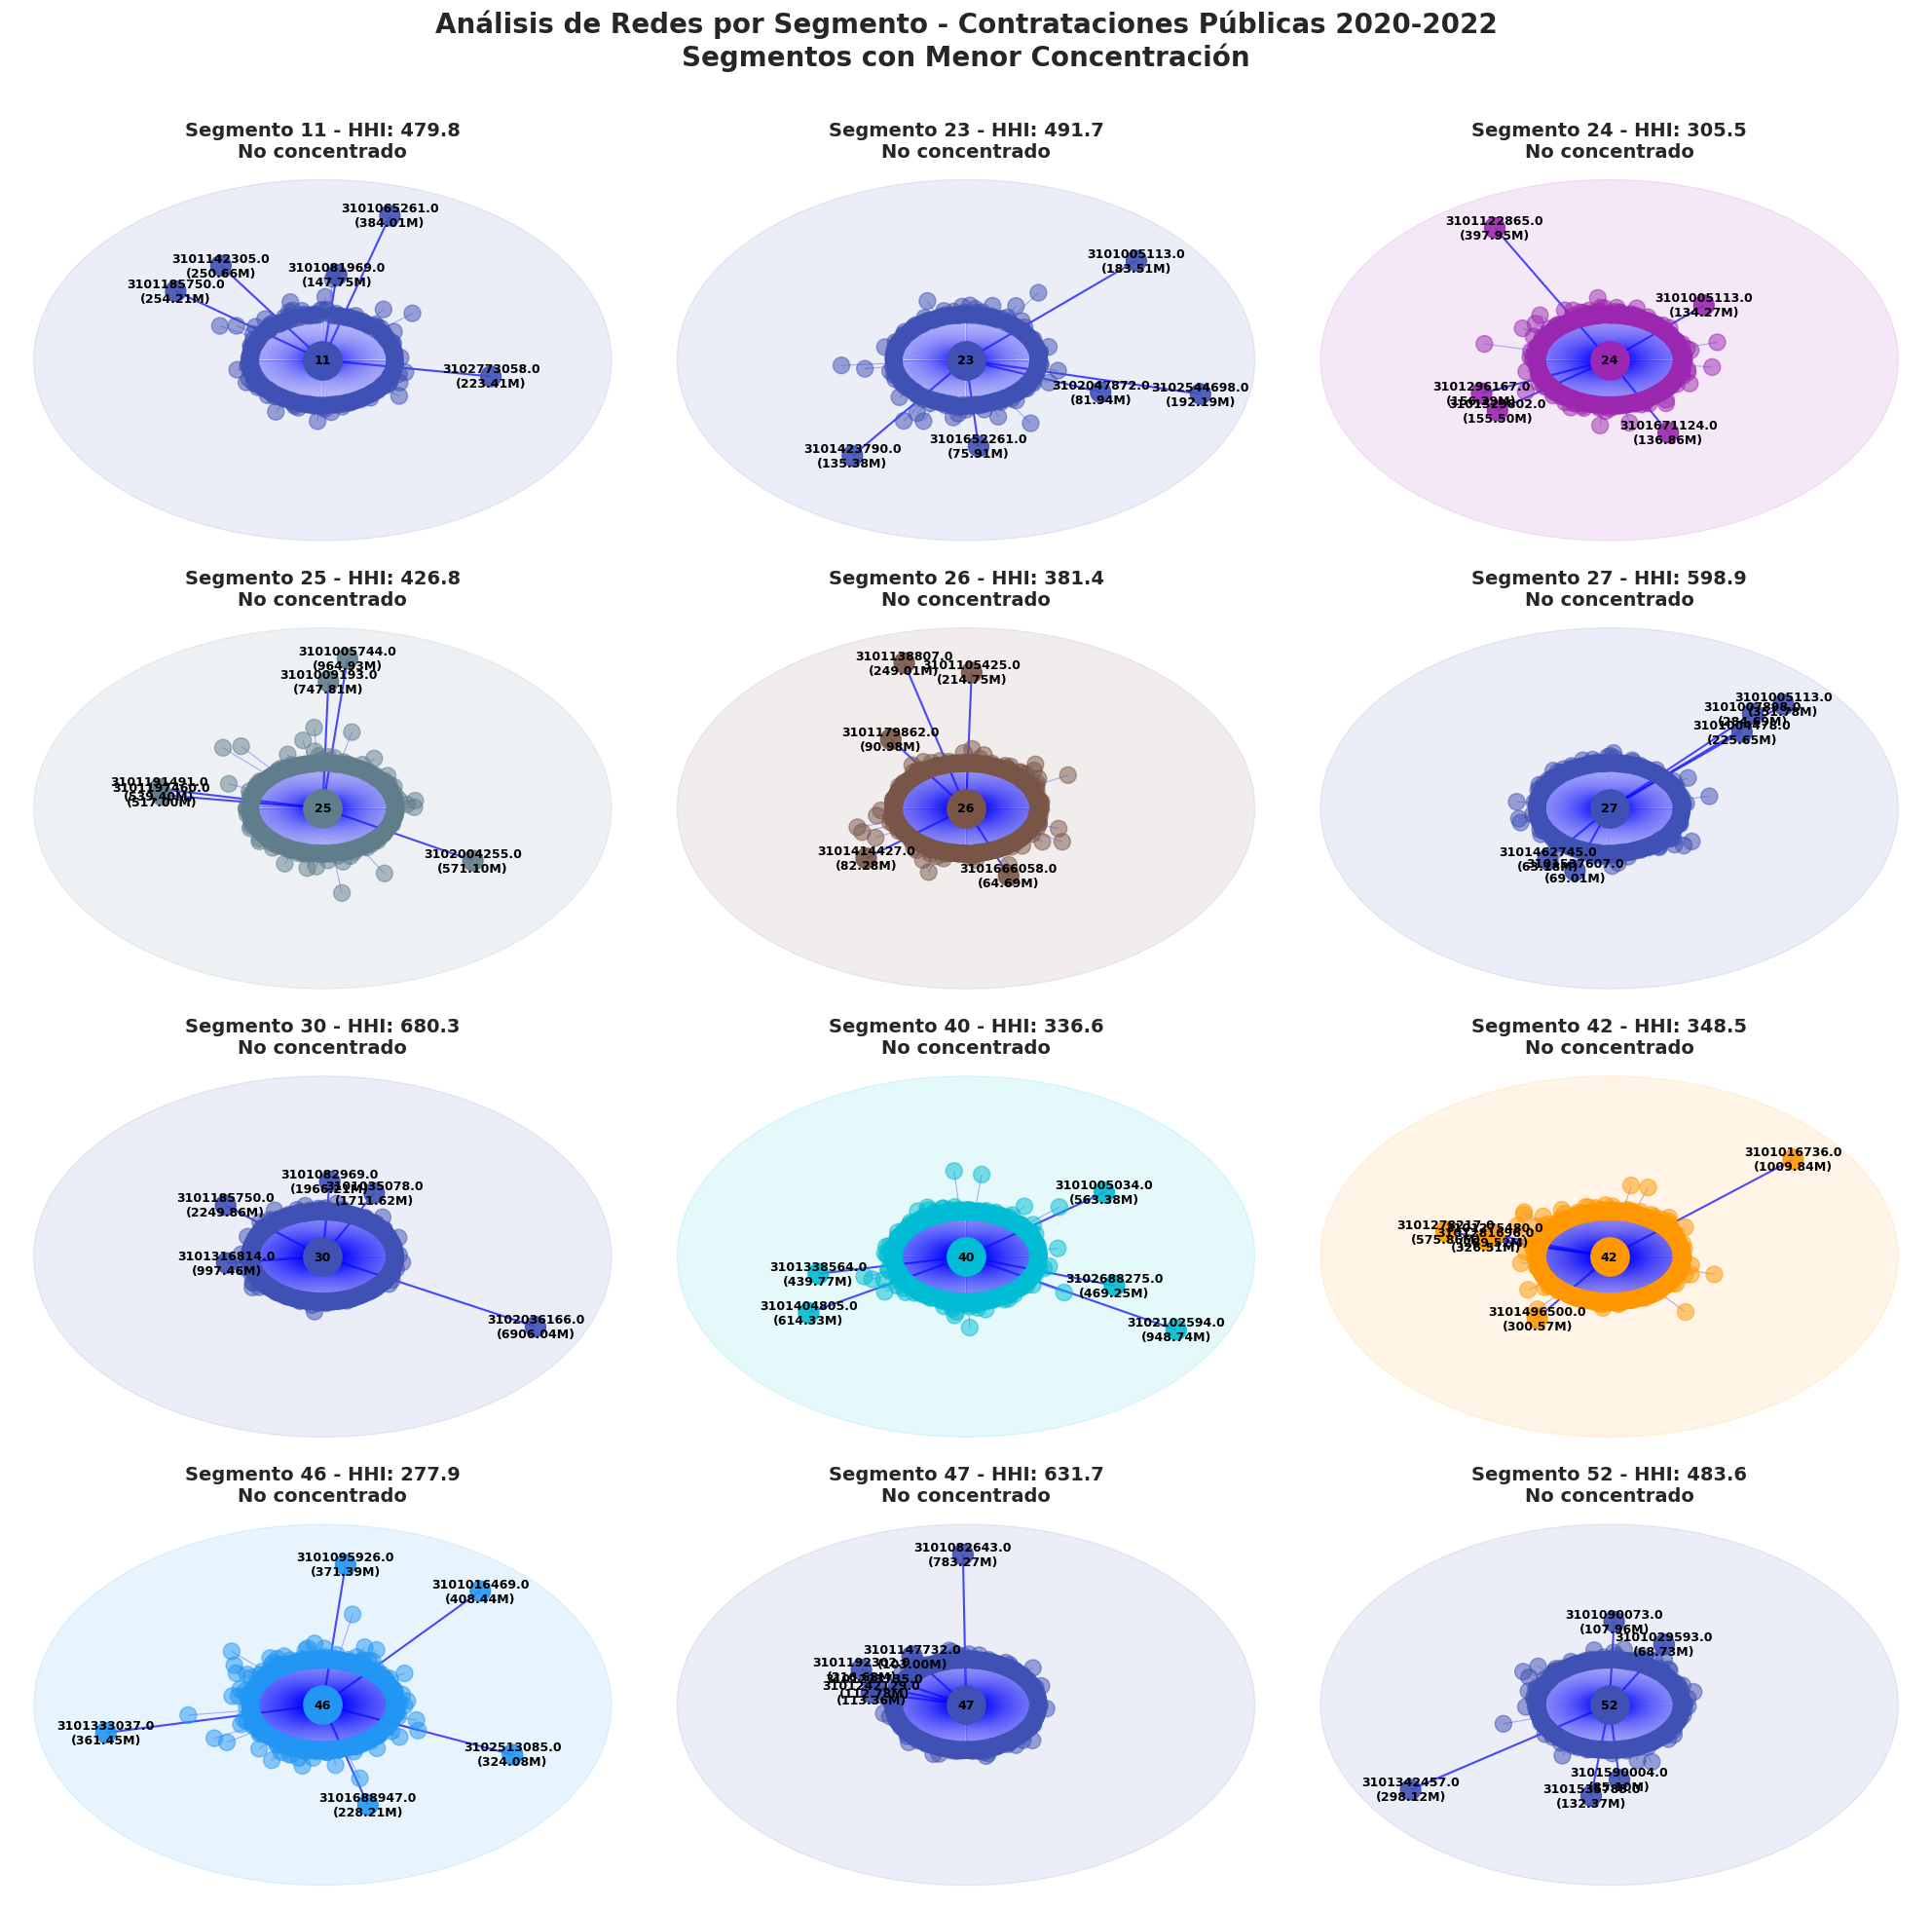

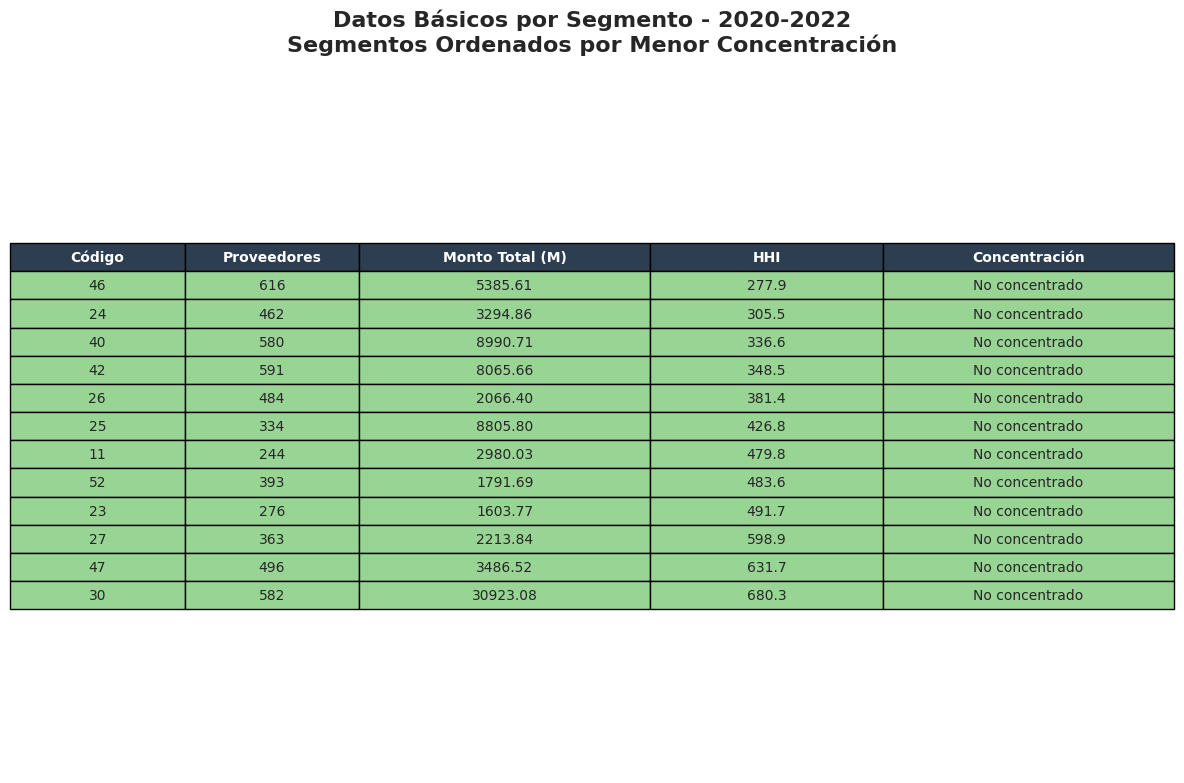

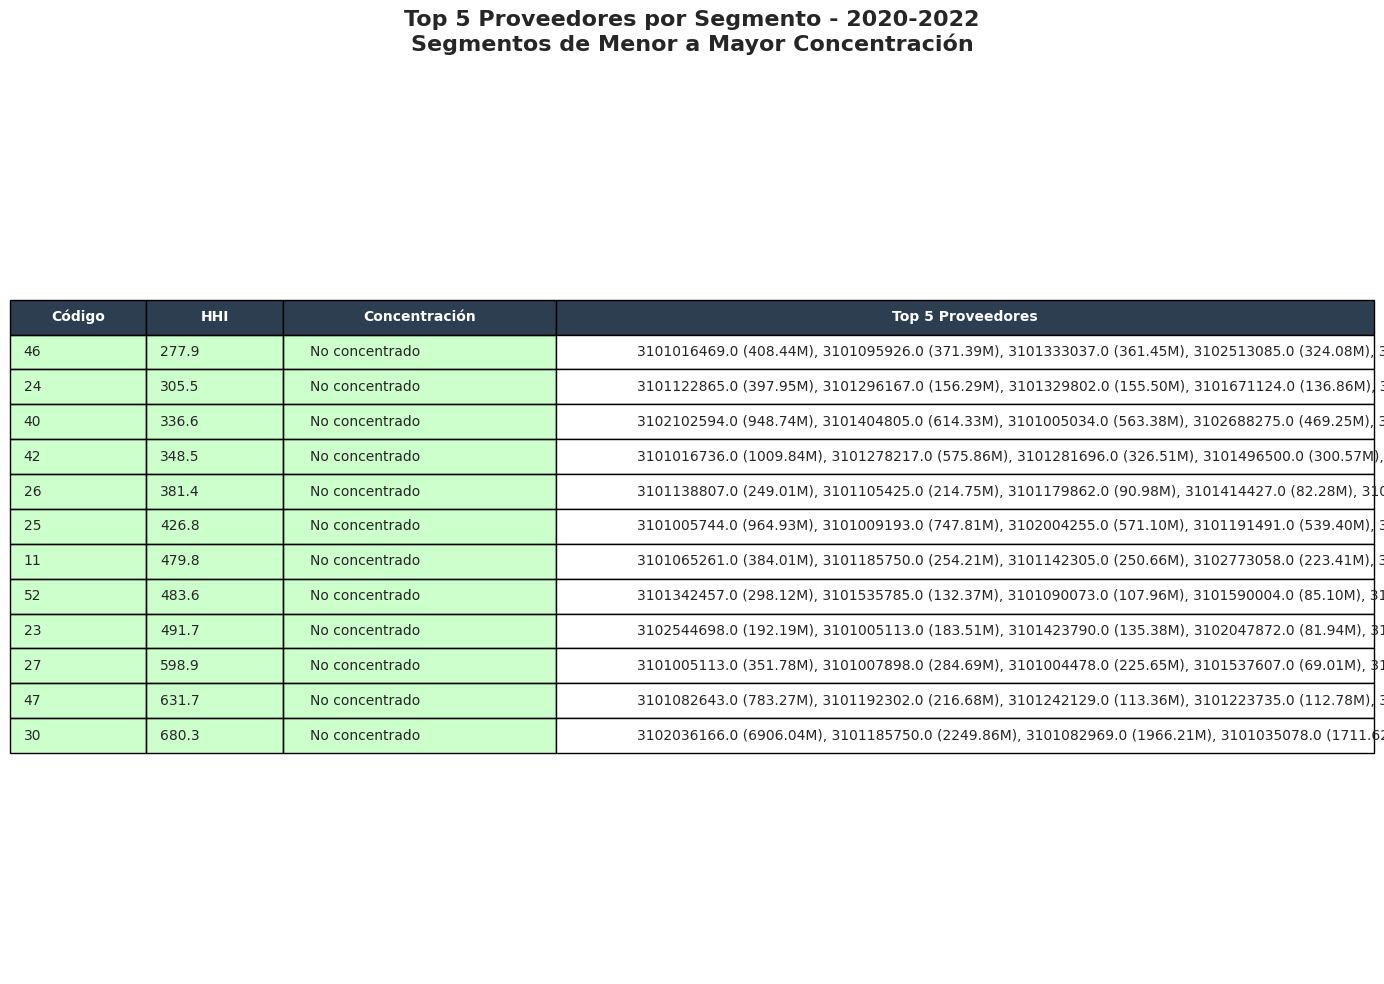

In [ ]:
analizar_redes_segmentos("/content/2020a2022.csv","/content/resultados_hhi_segmentos_2020-2022.csv",'2020-2022',n_segmentos=20)

Cargando datos originales desde /content/2023a2024.csv...
Cargando datos HHI desde /content/resultados_hhi_segmentos_2023-2024.csv...
Analizando 20 segmentos: [90, 43, 81, 78, 86, 30, 73, 24, 70, 44, 40, 39, 60, 42, 41, 52, 93, 47, 11, 27]
Se encontraron 213040 transacciones para los segmentos seleccionados.
Generando visualizaciones para el período 2023-2024...
Imágenes guardadas en el directorio: .


{'redes': './redes_por_segmento_2023-2024.png',
 'tabla_basica': './datos_basicos_segmento_2023-2024.png',
 'top5_proveedores': './top5_proveedores_segmento_2023-2024.png'}

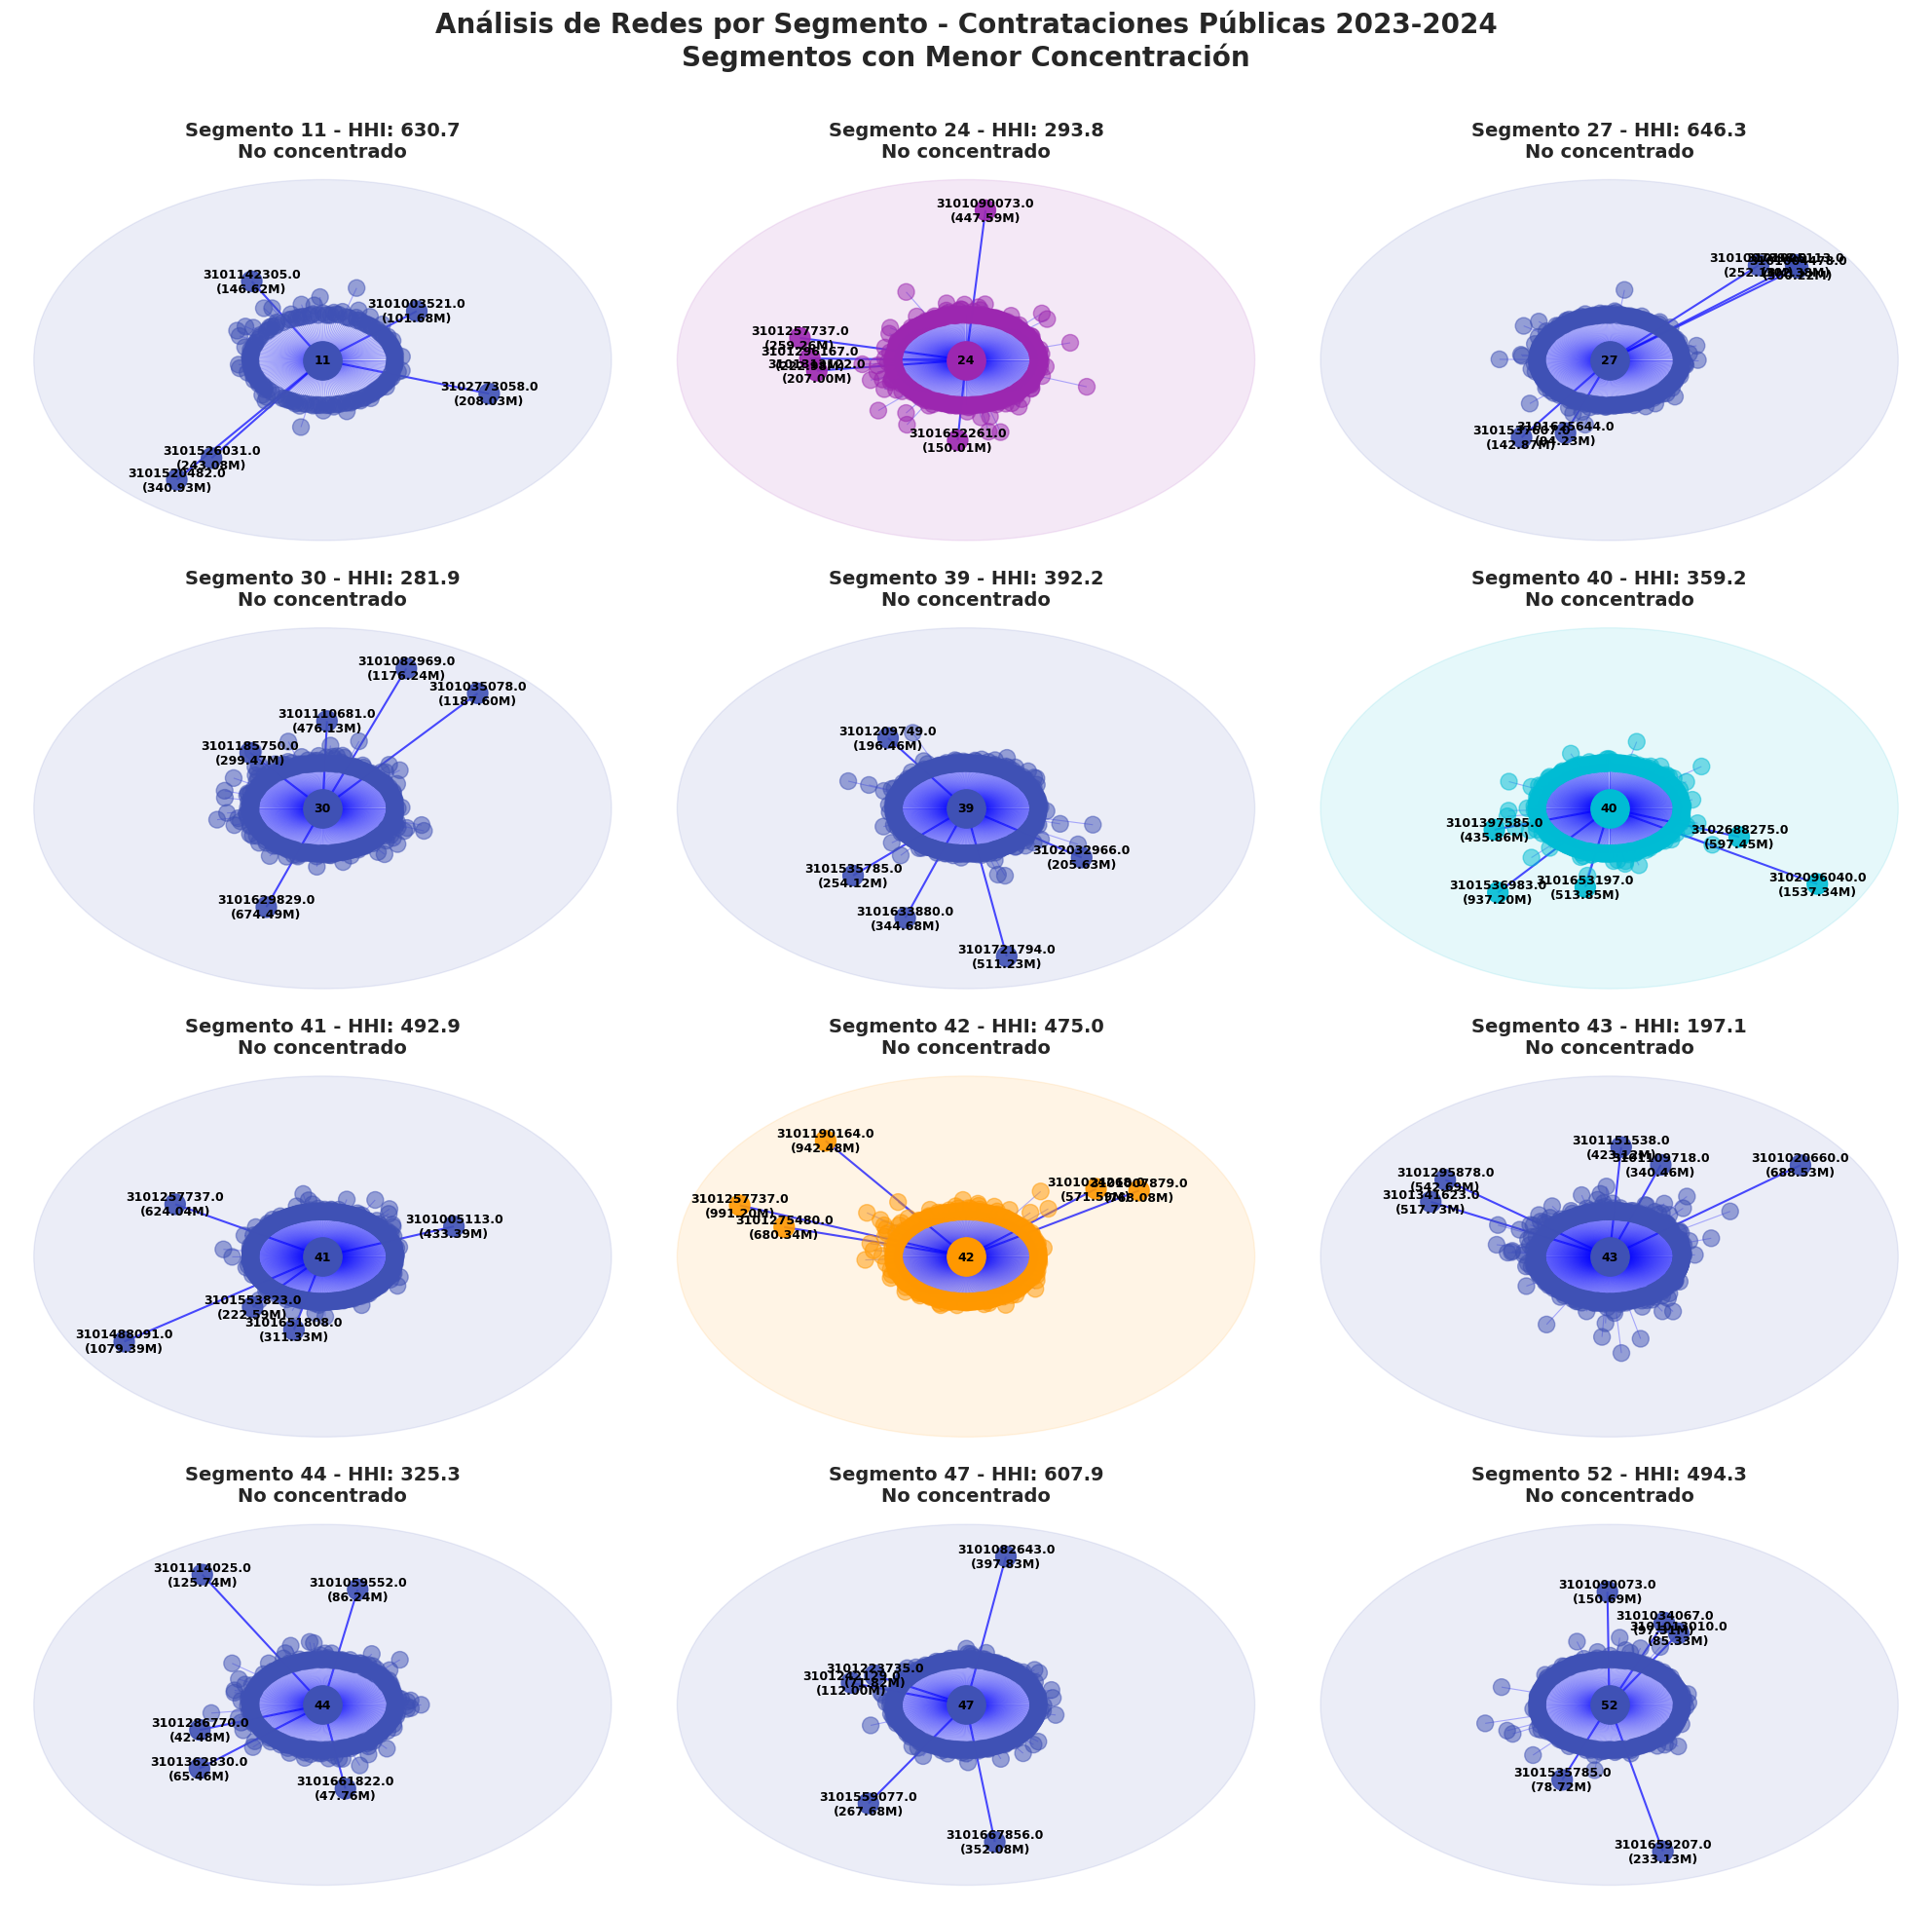

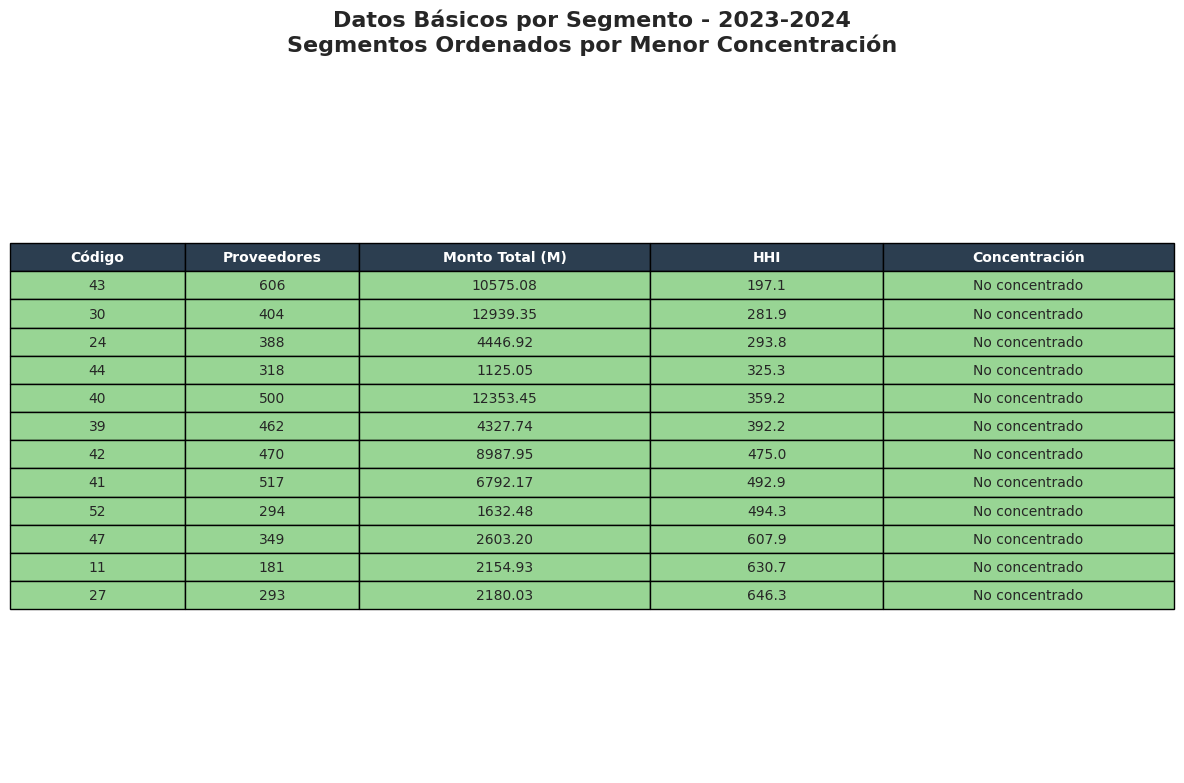

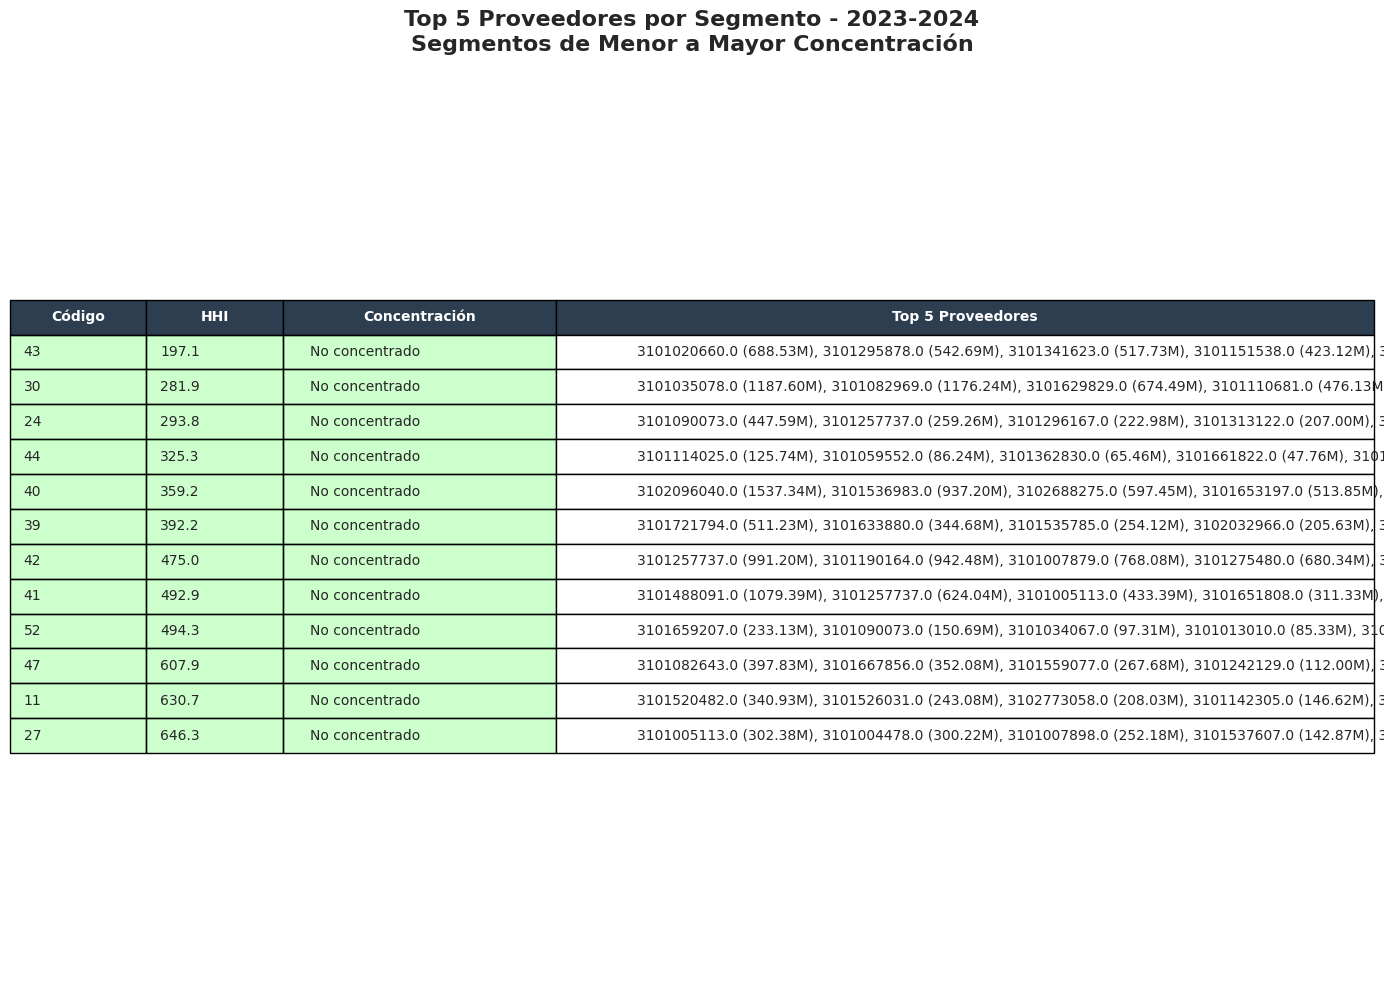

In [ ]:
analizar_redes_segmentos("/content/2023a2024.csv","/content/resultados_hhi_segmentos_2023-2024.csv",'2023-2024',n_segmentos=20)

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors

def analizar_concentracion(csv_path, periodo_nombre):
    """
    Analiza la concentración de proveedores en compras públicas para un período específico.

    Args:
        csv_path (str): Ruta al archivo CSV con los datos.
        periodo_nombre (str): Nombre del período al que corresponden los datos.

    Returns:
        dict: Resultados del análisis del período.
    """
    # Leer el CSV
    try:
        df = pd.read_csv(csv_path)
    except Exception as e:
        return {'error': f'Error al leer el archivo CSV: {str(e)}'}

    # Verificar columnas requeridas
    columnas_requeridas = ['segment_code', 'hhi', 'num_transactions', 'num_providers', 'concentration']
    columnas_faltantes = [col for col in columnas_requeridas if col not in df.columns]

    if columnas_faltantes:
        return {'error': f'Faltan columnas requeridas: {", ".join(columnas_faltantes)}'}

    # Función para calcular la moda
    def calcular_moda(valores):
        if not valores:
            return None
        contador = Counter(valores)
        max_frecuencia = max(contador.values())
        return [val for val, freq in contador.items() if freq == max_frecuencia]

    # Resultados del período
    resultados = {}

    # Usar todos los datos como un solo período con el nombre proporcionado
    datos_periodo = df

    if datos_periodo.empty:
        resultados[periodo_nombre] = {
            'cantidad_registros': 0,
            'mensaje': f'No se encontraron datos para el período {periodo_nombre}'
        }
        return resultados

    # Agrupar por segment_code
    segmentos_periodo = datos_periodo.groupby('segment_code')

    # Analizar cada segmento
    analisis_segmentos = []

    for segmento, datos in segmentos_periodo:
        # Calcular HHI promedio del segmento
        hhi_values = datos['hhi'].dropna().tolist()
        hhi_promedio = np.mean(hhi_values) if hhi_values else None
        hhi_moda = calcular_moda(hhi_values) if hhi_values else None

        # Calcular concentración predominante
        if 'concentration' in datos.columns:
            concentracion_counts = datos['concentration'].value_counts()
            concentracion_predominante = concentracion_counts.index[0] if not concentracion_counts.empty else None
        else:
            concentracion_predominante = None

        # Contar proveedores únicos si existe la columna
        if 'num_providers' in datos.columns:
            proveedores_unicos = datos['num_providers'].nunique()
        else:
            proveedores_unicos = None

        analisis_segmentos.append({
            'segmento': segmento,
            'cantidad_transacciones': len(datos),
            'proveedores_unicos': proveedores_unicos,
            'hhi_promedio': hhi_promedio,
            'hhi_moda': hhi_moda,
            'concentracion_predominante': concentracion_predominante,
        })

    # Ordenar segmentos por HHI promedio (ascendente)
    analisis_segmentos_ordenados = sorted(
        [s for s in analisis_segmentos if s['hhi_promedio'] is not None],
        key=lambda x: x['hhi_promedio']
    )

    # Estadísticas generales del período
    hhi_todos = datos_periodo['hhi'].dropna().tolist()

    resultados[periodo_nombre] = {
        'cantidad_registros': len(datos_periodo),
        'cantidad_segmentos': len(segmentos_periodo.groups),
        'hhi_promedio_periodo': np.mean(hhi_todos) if hhi_todos else None,
        'hhi_moda_periodo': calcular_moda(hhi_todos) if hhi_todos else None,
        'segmentos_menor_concentracion': analisis_segmentos_ordenados[:10] if len(analisis_segmentos_ordenados) >= 10 else analisis_segmentos_ordenados,
        'segmentos_mayor_concentracion': analisis_segmentos_ordenados[-10:][::-1] if len(analisis_segmentos_ordenados) >= 10 else analisis_segmentos_ordenados[::-1],
        'todos_segmentos': analisis_segmentos_ordenados  # Guardar todos los segmentos para análisis
    }

    return resultados

def obtener_segmentos_baja_concentracion(resultado_periodo1, resultado_periodo2):
    """
    Identifica segmentos que mantienen baja concentración en ambos períodos.

    Args:
        resultado_periodo1 (dict): Resultados del primer período.
        resultado_periodo2 (dict): Resultados del segundo período.

    Returns:
        dict: Segmentos con baja concentración en ambos períodos.
    """
    # Verificar si hay errores en los resultados
    if 'error' in resultado_periodo1 or 'error' in resultado_periodo2:
        return {
            'error': 'Error en los datos de entrada',
            'detalle': resultado_periodo1.get('error', '') + ' ' + resultado_periodo2.get('error', '')
        }

    nombre_periodo1 = list(resultado_periodo1.keys())[0]
    nombre_periodo2 = list(resultado_periodo2.keys())[0]

    datos_periodo1 = resultado_periodo1[nombre_periodo1]
    datos_periodo2 = resultado_periodo2[nombre_periodo2]

    # Obtener promedio y moda de HHI para cada período
    hhi_promedio1 = datos_periodo1.get('hhi_promedio_periodo')
    hhi_promedio2 = datos_periodo2.get('hhi_promedio_periodo')

    # Obtener todos los segmentos
    segmentos_periodo1 = {s['segmento']: s for s in datos_periodo1.get('todos_segmentos', [])}
    segmentos_periodo2 = {s['segmento']: s for s in datos_periodo2.get('todos_segmentos', [])}

    # Encontrar segmentos comunes
    segmentos_comunes = set(segmentos_periodo1.keys()) & set(segmentos_periodo2.keys())

    # Filtrar segmentos con baja concentración en ambos períodos
    segmentos_baja_concentracion = []

    for segmento in segmentos_comunes:
        datos1 = segmentos_periodo1[segmento]
        datos2 = segmentos_periodo2[segmento]

        concentracion1 = datos1.get('concentracion_predominante', '')
        concentracion2 = datos2.get('concentracion_predominante', '')

        # Verificar si ambos períodos tienen "No concentrado"
        if "No concentrado" in str(concentracion1) and "No concentrado" in str(concentracion2):
            hhi1 = datos1.get('hhi_promedio')
            hhi2 = datos2.get('hhi_promedio')

            if hhi1 is not None and hhi2 is not None:
                variacion = ((hhi2 - hhi1) / hhi1) * 100 if hhi1 != 0 else float('inf')

                # Determinar si la concentración aumentó o disminuyó
                tendencia = "▼" if variacion < 0 else "▲"

                # Evaluar posibilidad de mayor flexibilidad
                # Criterios para determinar flexibilidad
                es_muy_bajo1 = hhi1 < (hhi_promedio1 * 0.5) if hhi_promedio1 else False
                es_muy_bajo2 = hhi2 < (hhi_promedio2 * 0.5) if hhi_promedio2 else False

                if es_muy_bajo1 and es_muy_bajo2 and variacion <= 0:
                    flexibilidad = "Alta"
                elif es_muy_bajo2:
                    flexibilidad = "Media-Alta"
                elif variacion < 0:
                    flexibilidad = "Media"
                else:
                    flexibilidad = "Media-Baja"

                segmentos_baja_concentracion.append({
                    'segmento': segmento,
                    'hhi1': hhi1,
                    'hhi2': hhi2,
                    'variacion': variacion,
                    'tendencia': tendencia,
                    'flexibilidad': flexibilidad,
                    'concentracion1': concentracion1,
                    'concentracion2': concentracion2
                })

    # Ordenar por flexibilidad y luego por HHI del segundo período
    orden_flexibilidad = {"Alta": 1, "Media-Alta": 2, "Media": 3, "Media-Baja": 4}
    segmentos_baja_concentracion = sorted(
        segmentos_baja_concentracion,
        key=lambda x: (orden_flexibilidad.get(x['flexibilidad'], 5), x['hhi2'])
    )

    return {
        'tabla_general': {
            'promedio_periodo1': hhi_promedio1,
            'promedio_periodo2': hhi_promedio2,
            'variacion_promedio': ((hhi_promedio2 - hhi_promedio1) / hhi_promedio1 * 100) if hhi_promedio1 and hhi_promedio1 != 0 else 0
        },
        'segmentos_baja_concentracion': segmentos_baja_concentracion
    }

def generar_tabla_imagen(resultado_analisis, ruta_imagen="segmentos_baja_concentracion.png"):
    """
    Genera una imagen de la tabla de segmentos con baja concentración para incluir en informes.

    Args:
        resultado_analisis (dict): Resultados del análisis de baja concentración.
        ruta_imagen (str): Ruta donde guardar la imagen generada.

    Returns:
        str: Ruta de la imagen generada.
    """
    # Verificar si hay errores en el resultado
    if 'error' in resultado_analisis:
        print(f"Error: {resultado_analisis['error']}")
        return None

    tabla_general = resultado_analisis['tabla_general']
    segmentos = resultado_analisis['segmentos_baja_concentracion']

    # Calcular variación en promedio
    promedio1 = tabla_general.get('promedio_periodo1', 0)
    promedio2 = tabla_general.get('promedio_periodo2', 0)
    variacion_promedio = tabla_general.get('variacion_promedio', 0)
    tendencia_promedio = "▼" if variacion_promedio < 0 else "▲"

    # Crear la figura para la imagen
    plt.rcParams.update({'font.size': 11, 'font.family': 'sans-serif'})

    # Altura adaptativa según la cantidad de filas
    num_rows_summary = 2  # Filas de la tabla resumen
    num_rows_segments = min(20, len(segmentos))  # Limitar a 20 filas como máximo

    # Calcular altura de la figura
    fig_height = 3 + (0.5 * num_rows_summary) + (0.5 * num_rows_segments)

    # Crear figura con dos secciones
    fig = plt.figure(figsize=(12, fig_height), dpi=120)
    gs = GridSpec(2, 1, height_ratios=[1, 2])

    # Configurar color de fondo y estilo
    fig.patch.set_facecolor("#F0F9FF")  # Color de fondo azul claro

    # Añadir título
    fig.suptitle("ANÁLISIS DE CONCENTRACIÓN DE PROVEEDORES EN COMPRAS PÚBLICAS",
                 fontsize=16, fontweight='bold', color="#1E40AF", y=0.98)

    # Primera tabla: Indicadores por período
    ax1 = plt.subplot(gs[0])
    ax1.axis('off')
    ax1.set_title("Índice HHI por Período", fontsize=14, fontweight='bold', color="#1E40AF", pad=20)

    # Crear la primera tabla
    rows_data = [
        ["Promedio HHI", f"{promedio1:.2f}", f"{promedio2:.2f}",
         f"{tendencia_promedio} {abs(variacion_promedio):.2f}%"]
    ]

    # Colores para la tabla
    header_color = "#1E40AF"  # Azul oscuro
    cell_color = "#F9FAFB"  # Gris muy claro

    # Crear la primera tabla con estilos
    table1 = ax1.table(
        cellText=rows_data,
        colLabels=["Indicador", "Periodo2020-2022", "Periodo2023-2024", "Variación"],
        loc='center',
        cellLoc='center',
        bbox=[0.1, 0.1, 0.8, 0.8]
    )

    # Establecer estilos de la primera tabla
    table1.auto_set_font_size(False)
    table1.set_fontsize(10)

    # Estilo para encabezados
    for j, cell in enumerate(table1._cells[(0, j)] for j in range(4)):
        cell.set_facecolor(header_color)
        cell.set_text_props(color='white', fontweight='bold')
        cell.set_height(0.15)

    # Estilo para celdas de datos
    for i in range(1, 2):
        for j in range(4):
            cell = table1._cells[(i, j)]
            cell.set_facecolor(cell_color if i % 2 else "white")
            # Color de texto para la columna de variación
            if j == 3 and i == 1:  # Variación del promedio
                cell.set_text_props(color='green' if tendencia_promedio == "▼" else 'red', fontweight='bold')

    # Ajustar anchos de columna
    col_widths = [0.2, 0.3, 0.3, 0.2]
    for j, width in enumerate(col_widths):
        for i in range(2):  # Incluye header y una fila
            if (i, j) in table1._cells:
                table1._cells[(i, j)].set_width(width)

    # Segunda tabla: Segmentos con baja concentración
    ax2 = plt.subplot(gs[1])
    ax2.axis('off')
    ax2.set_title(f"Segmentos con baja concentración en ambos períodos ({len(segmentos)})",
                 fontsize=14, fontweight='bold', color="#1E40AF", pad=20)

    # Preparar datos para la segunda tabla
    rows_segments = []

    for item in segmentos[:num_rows_segments]:  # Limitar a 20 filas como máximo
        variacion_str = f"{item['tendencia']} {abs(item['variacion']):.2f}%"
        rows_segments.append([
            str(item['segmento']),
            f"{item['hhi1']:.2f}",
            f"{item['hhi2']:.2f}",
            variacion_str,
            item['flexibilidad']
        ])

    # Crear la segunda tabla con estilos
    table2 = ax2.table(
        cellText=rows_segments,
        colLabels=["Segmento", "HHI Periodo2020-2022", "HHI Periodo2023-2024",
                   "Variación", "Posibilidad de Mayor Flexibilidad"],
        loc='center',
        cellLoc='center',
        bbox=[0.05, 0.05, 0.9, 0.8]
    )

    # Establecer estilos de la segunda tabla
    table2.auto_set_font_size(False)
    table2.set_fontsize(10)

    # Estilo para encabezados
    for j, cell in enumerate(table2._cells[(0, j)] for j in range(5)):
        cell.set_facecolor(header_color)
        cell.set_text_props(color='white', fontweight='bold')
        cell.set_height(0.1)

    # Estilo para celdas de datos
    for i in range(1, len(rows_segments) + 1):
        for j in range(5):
            cell = table2._cells[(i, j)]
            cell.set_facecolor(cell_color if i % 2 else "white")

            # Color para flexibilidad
            if j == 4:  # Columna de flexibilidad
                item = segmentos[i-1]
                flex_val = item['flexibilidad']
                # Asignar colores según flexibilidad
                if flex_val == "Alta":
                    cell.set_facecolor("#10B981")  # Verde
                elif flex_val == "Media-Alta":
                    cell.set_facecolor("#34D399")  # Verde claro
                elif flex_val == "Media":
                    cell.set_facecolor("#FBBF24")  # Amarillo
                else:
                    cell.set_facecolor("#F97316")  # Naranja
                cell.set_text_props(color='white', fontweight='bold')

            # Color para variación
            if j == 3:  # Columna de variación
                item = segmentos[i-1]
                cell.set_text_props(color='green' if item['tendencia'] == "▼" else 'red', fontweight='bold')

    # Ajustar anchos de columna
    col_widths = [0.1, 0.2, 0.2, 0.2, 0.3]
    for j, width in enumerate(col_widths):
        for i in range(len(rows_segments) + 1):  # Incluye header y filas de datos
            if (i, j) in table2._cells:
                table2._cells[(i, j)].set_width(width)

    # Añadir notas explicativas
    plt.figtext(0.1, 0.05, "Notas:", fontweight='bold', fontsize=10)
    plt.figtext(0.1, 0.03, "▼ indica disminución en la concentración (mejora en competitividad)", fontsize=9)
    plt.figtext(0.1, 0.01, "▲ indica aumento en la concentración (empeoramiento en competitividad)", fontsize=9)
    plt.figtext(0.6, 0.05, "Criterios de Flexibilidad:", fontweight='bold', fontsize=10)
    plt.figtext(0.6, 0.03, " HHI muy bajo en ambos períodos, tendencia a la baja y mercado no concentrado", fontsize=9)


    # Ajustar espaciado y guardar
    plt.tight_layout(rect=[0, 0.06, 1, 0.95])
    plt.savefig(ruta_imagen, dpi=150, bbox_inches='tight')
    plt.close()

    print(f"\nSe ha generado la imagen de la tabla en: {ruta_imagen}")
    return ruta_imagen

def analizar_y_comparar_concentracion(csv_periodo1, csv_periodo2):
    """
    Función principal para analizar ambos períodos y extraer segmentos con baja concentración.

    Args:
        csv_periodo1 (str): Ruta al CSV del primer período.
        csv_periodo2 (str): Ruta al CSV del segundo período.

    Returns:
        dict: Resultados del análisis.
    """
    try:
        # Analizar cada período
        resultado_periodo1 = analizar_concentracion(csv_periodo1, "Periodo2020-2022")
        resultado_periodo2 = analizar_concentracion(csv_periodo2, "Periodo2023-2024")

        # Verificar si hay errores en los resultados
        if 'error' in resultado_periodo1:
            return {'error': f'Error en el primer período: {resultado_periodo1["error"]}'}
        if 'error' in resultado_periodo2:
            return {'error': f'Error en el segundo período: {resultado_periodo2["error"]}'}

        # Obtener segmentos con baja concentración
        resultado_baja_concentracion = obtener_segmentos_baja_concentracion(
            resultado_periodo1, resultado_periodo2
        )

        # Generar tabla de resumen como imagen
        ruta_imagen = generar_tabla_imagen(resultado_baja_concentracion)

        # Añadir ruta de la imagen al resultado
        if ruta_imagen:
            resultado_baja_concentracion['ruta_imagen'] = ruta_imagen

        # Mostrar resumen en consola
        print(f"\n{'=' * 70}")
        print("SEGMENTOS CON BAJA CONCENTRACIÓN EN AMBOS PERÍODOS")
        print(f"{'=' * 70}")
        print(f"Total de segmentos con baja concentración: {len(resultado_baja_concentracion['segmentos_baja_concentracion'])}")

        tabla_general = resultado_baja_concentracion['tabla_general']
        print(f"\nPromedio HHI 2020-2022: {tabla_general['promedio_periodo1']:.2f}")
        print(f"Promedio HHI 2023-2024: {tabla_general['promedio_periodo2']:.2f}")

        print("\nDetalle de segmentos:")
        print(f"{'Segmento':<10} | {'HHI 2020-2022':<15} | {'HHI 2023-2024':<15} | {'Variación':<12} | {'Flexibilidad':<15}")
        print(f"{'-' * 10} | {'-' * 15} | {'-' * 15} | {'-' * 12} | {'-' * 15}")

        for item in resultado_baja_concentracion['segmentos_baja_concentracion']:
            tendencia = "▼" if item['variacion'] < 0 else "▲"
            print(f"{item['segmento']:<10} | {item['hhi1']:<15.2f} | {item['hhi2']:<15.2f} | {tendencia} {abs(item['variacion']):<9.2f}% | {item['flexibilidad']:<15}")

        return resultado_baja_concentracion

    except Exception as e:
        import traceback
        traceback.print_exc()
        return {'error': str(e)}

# Para ejecutar el análisis, descomentar y proporcionar las rutas a los archivos CSV
# resultado = analizar_y_comparar_concentracion("datos_2020_2022.csv", "datos_2023_2024.csv")

In [ ]:
# Ejemplo de uso
if __name__ == "__main__":
    # Reemplazar con las rutas reales a los archivos CSV
    csv_periodo1 = "/content/resultados_hhi_segmentos_2020-2022.csv"
    csv_periodo2 = "/content/resultados_hhi_segmentos_2023-2024.csv"

    resultados = analizar_y_comparar_concentracion(csv_periodo1, csv_periodo2)

    print("\nAnálisis completado. Se ha generado una imagen con la tabla de resumen.")
    print(f"Ruta de la imagen: {resultados.get('ruta_imagen', 'No disponible')}")


Se ha generado la imagen de la tabla en: segmentos_baja_concentracion.png

SEGMENTOS CON BAJA CONCENTRACIÓN EN AMBOS PERÍODOS
Total de segmentos con baja concentración: 29

Promedio HHI 2020-2022: 1995.27
Promedio HHI 2023-2024: 1820.35

Detalle de segmentos:
Segmento   | HHI 2020-2022   | HHI 2023-2024   | Variación    | Flexibilidad   
---------- | --------------- | --------------- | ------------ | ---------------
78         | 330.26          | 210.73          | ▼ 36.19    % | Alta           
86         | 918.98          | 235.45          | ▼ 74.38    % | Alta           
30         | 680.27          | 281.92          | ▼ 58.56    % | Alta           
24         | 305.45          | 293.83          | ▼ 3.80     % | Alta           
60         | 917.95          | 453.93          | ▼ 50.55    % | Alta           
47         | 631.70          | 607.90          | ▼ 3.77     % | Alta           
51         | 761.64          | 710.25          | ▼ 6.75     % | Alta           
81         | 1226.2